# Mental Health Analysis ProjectA 

The purpose of this project is ...

# Data Scrapping

Reddit data

In [1]:
# scrapping data from reddit api
import requests
import pandas as pd
# import praw
import emoji
import emot
import asyncpraw
# import asyncio
from tqdm import tqdm
# loading json
import json
# load a kaomoji_to_text.json
kaomoji_to_text = json.load(open('./kaomoji_to_text.json', 'r', encoding='utf-8'))


import os
from dotenv import load_dotenv
load_dotenv()




class RedditScraper:


    def __init__(self):

        self.auth = requests.auth.HTTPBasicAuth(os.getenv('CLIENT_ID'), os.getenv('CLIENT_SECRET'))
        self.data = {'grant_type': 'password',
                     'username': os.getenv('USERNAME'),
                     'password': os.getenv('PASSWORD')}
        self.headers = {'User-Agent': 'MyAPI/0.0.1'}
        self.res = requests.post('https://www.reddit.com/api/v1/access_token',
                                auth=self.auth, data=self.data, headers=self.headers)
        
        self.headers["Authorization"] = f'bearer {self.res.json()["access_token"]}'



        self.client_id = os.getenv('CLIENT_ID')
        self.client_secret = os.getenv('CLIENT_SECRET')
        self.username = os.getenv('USERNAME')
        self.password = os.getenv('PASSWORD')





    def get_posts_byrequests(self, subreddit, limit=1000):
        url = f'https://oauth.reddit.com/r/{subreddit}/hot'
        params = {'limit': limit}
        response = requests.get(url, headers=self.headers, params=params)
        
        if response.status_code == 200:
            return response
        else:
            raise Exception(f"Error fetching posts: {response.status_code} - {response.text}")
        


    def convert_emojis_emoticons(self, text):


        # Replace kaomojis with their text equivalents
        for kaomoji, text_representation in kaomoji_to_text.items():
            # if kaomoji is in text, replace it with text_representation
            if kaomoji in text:
                text = text.replace(kaomoji, f" {text_representation} ")


        e = emot.core.emot()

        # Extract emoticons
        emoticon_results = e.emoticons(text)
        for original, meaning in zip(emoticon_results['value'], emoticon_results['mean']):
            text = text.replace(original, f" {meaning} ")

        # Extract emojis
        # emoji_results = e.emoji(text)
        # for original, meaning in zip(emoji_results['value'], emoji_results['mean']):
        #     text = text.replace(original, f" {meaning} ")
        
        # Extract emojis
        text = emoji.demojize(text)


        return text.strip().lower()
        


    async def get_posts_byprawn(self, subreddits, limit=1000, mental="mental_"):

        reddit = asyncpraw.Reddit(client_id=self.client_id,
                             client_secret=self.client_secret,
                             user_agent='windows:mentalhealth.scraper:v1.0 (by u/IceWorth5480)',
                             username=self.username,
                             password=self.password)
        
        all_posts = []
        # , 'top', 'new'
        sort_types = ['hot', 'top', 'new']


        for subreddit_name in tqdm(subreddits, desc="Subreddits Progress"):
            subreddit = await reddit.subreddit(subreddit_name)
            for sort in sort_types:
                if sort == 'hot':
                    posts = subreddit.hot(limit=limit)
                elif sort == 'top':
                    posts = subreddit.top(limit=limit)
                elif sort == 'new':
                    posts = subreddit.new(limit=limit)

                async for post in posts:
                    if post is None:
                        continue

                    # Load top-level comments (non-blocking)
                    await post.load()
                    await post.comments.replace_more(limit=0)
                    top_comments_raw = [comment.body for comment in post.comments[:5]]  # Get top 5 comments
                    top_comments = [self.convert_emojis_emoticons(c) for c in top_comments_raw]

                    all_posts.append({
                        'id': post.id,
                        'subreddit': subreddit_name,
                        'sort': sort,
                        'title': post.title,
                        'selftext': self.convert_emojis_emoticons(post.selftext),
                        'created_utc': post.created_utc,
                        'score': post.score,
                        'num_comments': post.num_comments,
                        'author': str(post.author),
                        'post_url': post.url,
                        'over_18': post.over_18,
                        'flair': post.link_flair_text,
                        'top_comments': top_comments
                    })

        await reddit.close()



        df = pd.DataFrame(all_posts)
        # Drop duplicates by post ID
        df = df.drop_duplicates(subset='id').reset_index(drop=True)
        df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
        df = df.sort_values(by='created_utc', ascending=False).reset_index(drop=True)
        # Convert list of comments to string for CSV storage
        df['top_comments'] = df['top_comments'].apply(lambda x: ' | '.join(x) if isinstance(x, list) else '')



        # check if f'./data/reddit_data/{mental}reddit_posts.csv' exists, if so merging with df and # delete dupicates by id
        if os.path.exists(f'./data/reddit_data/{mental}reddit_posts.csv'):
            existing_df = pd.read_csv(f'./data/reddit_data/{mental}reddit_posts.csv')
            df = pd.concat([existing_df, df]).drop_duplicates(subset='id').reset_index(drop=True)
       
        # save as csv 
        df.to_csv(f'./data/reddit_data/{mental}reddit_posts.csv', index=False)


In [2]:



# mental_subreddits = ['mentalhealth', 'depression', 'anxiety', 'therapy', 'selfhelp', 'bpd', 'ptsd', 'socialanxiety', 'counseling']
mental_subreddits = ['selfharm','SuicideWatch']
normal_subreddits = ['popular','all','AskReddit','interestingasfuck']
# australian_regions = ['melbourne','sydney','adelaide','perth','brisbane','canberra']


scraper  = RedditScraper()

await scraper.get_posts_byprawn(mental_subreddits, limit=1000, mental="mental_")
# await scraper.get_posts_byprawn(normal_subreddits, limit=1000, mental="normal_")




Subreddits Progress: 100%|██████████| 2/2 [1:28:48<00:00, 2664.28s/it]


In [3]:
# read the csv file 

df_mental = pd.read_csv('./data/reddit_data/mental_reddit_posts.csv')
print(df_mental.shape)

df_normal = pd.read_csv('./data/reddit_data/normal_reddit_posts.csv')
print(df_normal.shape)

(25208, 13)
(2434, 13)


Beyond Blue forums 

In [ ]:



from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from datetime import datetime, timedelta
import calendar
import os
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException
from selenium.webdriver.chrome.options import Options
from selenium_stealth import stealth
from tqdm import tqdm
import emoji
import emot
import json
from concurrent.futures import ThreadPoolExecutor, as_completed

# Load kaomoji_to_text.json
kaomoji_to_text = json.load(open('./kaomoji_to_text.json', 'r', encoding='utf-8'))



def parse_post_date(raw_date):
    weekdays = [day.lower() for day in list(calendar.day_name)]
    today = datetime.now()
    raw_date = raw_date.strip().lower()

    # Handle "X hours ago" or "X minutes ago" as today
    if "hour" in raw_date or "m" in raw_date:
        return today.strftime('%Y-%m-%d')

    if raw_date in weekdays:
        post_weekday_index = weekdays.index(raw_date)
        today_weekday_index = today.weekday()
        delta_days = (today_weekday_index - post_weekday_index) % 7
        post_date = today - timedelta(days=delta_days)
        return post_date.strftime('%Y-%m-%d')

    elif "week" in raw_date:
        match = re.search(r'(\d+)', raw_date)
        weeks = int(match.group(1)) if match else 1
        post_date = today - timedelta(weeks=weeks)
        return post_date.strftime('%Y-%m-%d')

    elif "month" in raw_date:
        match = re.search(r'(\d+)', raw_date)
        months = int(match.group(1)) if match else 1
        post_date = today - timedelta(days=30 * months)
        return post_date.strftime('%Y-%m-%d')

    else:
        try:
            post_date = datetime.strptime(raw_date, '%d-%m-%Y')
            return post_date.strftime('%Y-%m-%d')
        except ValueError:
            print(f"[Warning] Invalid date format: {raw_date}")
            return None  # Recommended to avoid Post Date errors
            # return 'Unknown date'  # Revert to this if you prefer, but may cause errors


def convert_emojis_emoticons(text):
    for kaomoji, text_representation in kaomoji_to_text.items():
        if kaomoji in text:
            text = text.replace(kaomoji, f" {text_representation} ")

    e = emot.core.emot()
    emoticon_results = e.emoticons(text)
    for original, meaning in zip(emoticon_results['value'], emoticon_results['mean']):
        text = text.replace(original, f" {meaning} ")

    text = emoji.demojize(text)
    return text.strip().lower()




def comment_scrapping(url, comment_pages=1, wait_time=20):
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36")
    chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
    chrome_options.add_experimental_option('useAutomationExtension', False)
    chrome_options.add_argument("--disable-images")  # Disable images for faster loading

    service = Service(ChromeDriverManager().install())
    comment_driver = webdriver.Chrome(service=service, options=chrome_options)

    # Apply stealth settings
    stealth(comment_driver,
            languages=["en-US", "en"],
            vendor="Google Inc.",
            platform="Win32",
            webgl_vendor="Intel Inc.",
            renderer="Intel Iris OpenGL Engine",
            fix_hairline=True)

    comment_driver.set_page_load_timeout(45)  # Increased from 30 to 45 seconds
    list_comments = []

    try:
        for page in range(1, comment_pages + 1):
            max_retries = 2
            retry_count = 0
            while retry_count < max_retries:
                try:
                    comment_driver.get(url)
                    WebDriverWait(comment_driver, wait_time).until(
                        EC.presence_of_element_located((By.CLASS_NAME, 'linear-message-list'))
                    )
                    break
                except TimeoutException:
                    retry_count += 1
                    print(f"[Warning] Timeout loading comment page {page}, attempt {retry_count}/{max_retries}.")
                    if retry_count == max_retries:
                        print(f"[Warning] Skipped comment page {page} after {max_retries} attempts.")
                        break
                except WebDriverException as e:
                    print(f"[Error] WebDriver issue: {e}")
                    break

            if retry_count == max_retries:
                continue

            soup = BeautifulSoup(comment_driver.page_source, 'html.parser')
            comments_section = soup.find('div', class_='lia-component-message-list-detail-with-inline-editors')
            comments_section = comments_section.find('div', class_='linear-message-list message-list')
            if not comments_section:
                print(f"[Warning] No comments section found on page {page}.")
                break

            every_comments = comments_section.find_all('div', recursive=False)
            for comment in every_comments:
                try:
                    main_section = comment.find('div', class_='lia-quilt-row lia-quilt-row-message-main')
                    if not main_section:
                        continue
                    comment_text = main_section.get_text(separator=' ', strip=True)
                    cleaned_comment = convert_emojis_emoticons(comment_text)
                    list_comments.append(cleaned_comment)
                except Exception as e:
                    print(f"[Warning] Error parsing a comment: {e}")
                    continue

            next_page = soup.find('a', rel="next")
            if next_page:
                url = next_page['href']
                if not url.startswith('http'):
                    print(f"[Warning] Invalid next page link: {url}")
                    break
            else:
                break
            time.sleep(1)  # Add 1-second delay to avoid rate-limiting

    finally:
        comment_driver.quit()

    return ' ||| '.join(list_comments) if list_comments else ""






def beyondblue_scrapping(tag, address, pages=2):
    # Check existing posts to skip already scraped ones
    save_dir = './data/beyondblue_data'
    save_path = os.path.join(save_dir, f'{tag}_beyondblue_posts.csv')
    existing_post_ids = set()
    if os.path.exists(save_path):
        existing_df = pd.read_csv(save_path)
        existing_post_ids = set(existing_df['Post ID'].astype(str))

    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36")
    chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
    chrome_options.add_experimental_option('useAutomationExtension', False)
    chrome_options.add_argument("--disable-images")  # Disable images for faster loading

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)

    # Apply stealth settings
    stealth(driver,
            languages=["en-US", "en"],
            vendor="Google Inc.",
            platform="Win32",
            webgl_vendor="Intel Inc.",
            renderer="Intel Iris OpenGL Engine",
            fix_hairline=True)

    driver.set_page_load_timeout(45)  # Increased from 30 to 45 seconds
    url = address
    all_posts = []

    try:
        for page in tqdm(range(1, pages + 1), desc=f"Scraping {tag} pages"):
            max_retries = 2
            retry_count = 0
            while retry_count < max_retries:
                try:
                    driver.get(url)
                    WebDriverWait(driver, 8).until(  # Reduced from 10 to 8 seconds
                        EC.presence_of_element_located((By.CLASS_NAME, 'custom-message-list'))
                    )
                    break
                except TimeoutException:
                    retry_count += 1
                    print(f"[Warning] Timeout on page {page}, attempt {retry_count}/{max_retries}.")
                    if retry_count == max_retries:
                        print(f"[Warning] Skipped page {page} after {max_retries} attempts.")
                        break
                except WebDriverException as e:
                    print(f"[Error] WebDriver issue on page {page}: {e}")
                    break

            if retry_count == max_retries:
                continue

            soup = BeautifulSoup(driver.page_source, 'html.parser')
            # Save page source for debugging
            # with open(f'page_source_{tag}_{page}.html', 'w', encoding='utf-8') as f:
            #     f.write(soup.prettify())

            discussions_block = soup.find('div', class_='custom-message-list all-discussions')
            if not discussions_block:
                print(f"[Warning] No discussion list found on page {page}.")
                break

            discussions = discussions_block.find_all('article')
            post_links = []
            for post in discussions:
                try:
                    post_link = post.find('h3').find_all('a')[1].get('href')
                    post_id = post_link.split('/')[-1]
                    if post_id in existing_post_ids:
                        # print(f"Skipping already scraped post ID: {post_id}")
                        continue
                    post_links.append((post, f"https://forums.beyondblue.org.au{post_link}"))
                except Exception as e:
                    print(f"[Error] Skipping post due to error: {e}")
                    continue

            # Parallelize comment scraping
            def scrape_post(post_data):
                post, full_post_link = post_data
                try:
                    cat_side_info = post.find('aside')
                    category_info = cat_side_info.find('div', class_='custom-tile-category-content') if cat_side_info else None
                    post_category = category_info.find('a').text.strip() if category_info and category_info.find('a') else ""
                    raw_date = category_info.find('time').text.strip() if category_info and category_info.find('time') else ""
                    post_date = parse_post_date(raw_date)

                    if pd.to_datetime(post_date, errors='coerce') < pd.to_datetime('2015-01-01'):
                        print(f"Post date {post_date} is older than 2015-01-01, skipping post.")
                        return None

                    post_id = full_post_link.split('/')[-1]
                    comments = comment_scrapping(full_post_link, comment_pages=1)

                    title_tag = post.find('h3').find_all('a')[1]
                    post_title = convert_emojis_emoticons(title_tag.text.strip()) if title_tag else ""

                    content_tag = post.find('p', class_='body-text')
                    post_content = convert_emojis_emoticons(content_tag.text.strip()) if content_tag else ""

                    side_info = post.find('aside')
                    author_info = side_info.find('div', class_='custom-tile-author-info') if side_info else None
                    post_author = author_info.find('a').find('span').text.strip() if author_info and author_info.find('a') else ""
                    author_link = author_info.find('a').get('href') if author_info and author_info.find('a') else ""
                    user_id = author_link.split('user-id/')[-1] if 'user-id/' in author_link else ""

                    reply_info = post.find('li', class_='custom-tile-replies')
                    num_comments = reply_info.find('b').text.strip() if reply_info and reply_info.find('b') else "0"

                    return {
                        "Post ID": post_id,
                        "Post Title": post_title,
                        "Post Content": post_content,
                        "Post Author": post_author,
                        "User ID": user_id,
                        "Post Date": post_date,
                        "Post Category": post_category,
                        "Number of Comments": num_comments,
                        "Comments": comments
                    }
                except Exception as e:
                    print(f"[Error] Skipping post due to error: {e}")
                    return None

            # Use ThreadPoolExecutor for parallel comment scraping
            with ThreadPoolExecutor(max_workers=3) as executor:
                future_to_post = {executor.submit(scrape_post, post_data): post_data for post_data in post_links}
                for future in as_completed(future_to_post):
                    result = future.result()
                    if result:
                        all_posts.append(result)

            next_page = soup.find('li', class_='lia-paging-page-next lia-component-next')
            if next_page and next_page.find('a'):
                url = next_page.find('a')['href']
                time.sleep(1)  # Add 1-second delay to avoid rate-limiting
            else:
                print("No more pages to scrape.")
                break

            if page % 10 == 0:
                temp_df = pd.DataFrame(all_posts).drop_duplicates(subset='Post ID').reset_index(drop=True)
                temp_df['Post Date'] = pd.to_datetime(temp_df['Post Date'], errors='coerce')
                temp_df = temp_df.sort_values(by='Post Date', ascending=False).reset_index(drop=True)

                os.makedirs(save_dir, exist_ok=True)
                if os.path.exists(save_path):
                    existing_df = pd.read_csv(save_path)
                    temp_df = pd.concat([existing_df, temp_df]).drop_duplicates(subset='Post ID').reset_index(drop=True)

                temp_df.to_csv(save_path, index=False)
                print(f"💾 Auto-saved data to {save_path} at page {page}")

    finally:
        driver.quit()

    df = pd.DataFrame(all_posts).drop_duplicates(subset='Post ID').reset_index(drop=True)
    df = df[df['Post Date'].notna()]
    df['Post Date'] = pd.to_datetime(df['Post Date'], errors='coerce')
    df = df.sort_values(by='Post Date', ascending=False).reset_index(drop=True)


    os.makedirs(save_dir, exist_ok=True)
    if os.path.exists(save_path):
        existing_df = pd.read_csv(save_path)
        df = pd.concat([existing_df, df]).drop_duplicates(subset='Post ID').reset_index(drop=True)

    df.to_csv(save_path, index=False)
    print(f"✅ Data saved to {save_path} with {len(df)} total posts.")




In [2]:

mental_health_urls = {
    "Anxiety": "https://forums.beyondblue.org.au/t5/anxiety/bd-p/c1-sc2-b1?&sort=recent",
    "Depression": "https://forums.beyondblue.org.au/t5/depression/bd-p/c1-sc2-b2?&sort=recent",
    "PTSD": "https://forums.beyondblue.org.au/t5/ptsd-and-trauma/bd-p/c1-sc2-b3?&sort=recent",
    "Suicide_selfharm": "https://forums.beyondblue.org.au/t5/suicidal-thoughts-and-self-harm/bd-p/c1-sc2-b4?&sort=recent",
    # "Staying_well": "https://forums.beyondblue.org.au/t5/staying-well/bd-p/c1-sc3-b1?&sort=recent",
    # "Treament": "https://forums.beyondblue.org.au/t5/treatments-health-professionals/bd-p/c1-sc3-b2?&sort=recent",
    # "Relationship_family_issues":"https://forums.beyondblue.org.au/t5/relationship-and-family-issues/bd-p/c1-sc3-b3?&sort=recent",
    # "Youth":"https://forums.beyondblue.org.au/t5/young-people/bd-p/c1-sc4-b1?&sort=recent",
    # "Sex_identity":"https://forums.beyondblue.org.au/t5/sexuality-and-gender-identity/bd-p/c1-sc4-b2?&sort=recent",
    # "Multiculture":"https://forums.beyondblue.org.au/t5/multicultural-experiences/bd-p/c1-sc4-b3?&sort=recent",
    # "Grief_loss":"https://forums.beyondblue.org.au/t5/grief-and-loss/bd-p/c1-sc4-b4?&sort=recent"
}



for tag, address in mental_health_urls.items():
    try:
        beyondblue_scrapping(tag, address, pages = 150)
    except Exception as e:
        print(f"Error scraping {tag}: {e}")
        continue

Scraping Anxiety pages:   7%|▋         | 10/150 [07:00<1:36:04, 41.17s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 10


Scraping Anxiety pages:  13%|█▎        | 20/150 [14:15<1:36:06, 44.36s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 20


Scraping Anxiety pages:  20%|██        | 30/150 [21:20<1:23:46, 41.89s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 30


Scraping Anxiety pages:  27%|██▋       | 40/150 [28:16<1:17:23, 42.21s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 40


Scraping Anxiety pages:  31%|███       | 46/150 [32:32<1:13:34, 42.45s/it]

Post date 2013-05-09 is older than 2015-01-01, skipping post.


Scraping Anxiety pages:  33%|███▎      | 50/150 [35:28<1:14:03, 44.44s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 50


Scraping Anxiety pages:  40%|████      | 60/150 [42:39<1:05:46, 43.85s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 60


Scraping Anxiety pages:  47%|████▋     | 70/150 [49:49<57:37, 43.22s/it]  

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 70


Scraping Anxiety pages:  48%|████▊     | 72/150 [51:11<54:35, 42.00s/it]

Post date 2014-04-14 is older than 2015-01-01, skipping post.


Scraping Anxiety pages:  50%|█████     | 75/150 [53:20<53:16, 42.62s/it]

Post date 2013-04-06 is older than 2015-01-01, skipping post.


Scraping Anxiety pages:  51%|█████     | 76/150 [53:58<50:44, 41.14s/it]

Post date 2013-06-17 is older than 2015-01-01, skipping post.


Scraping Anxiety pages:  52%|█████▏    | 78/150 [55:14<47:38, 39.70s/it]

Post date 2013-05-06 is older than 2015-01-01, skipping post.
Post date 2013-05-06 is older than 2015-01-01, skipping post.


Scraping Anxiety pages:  53%|█████▎    | 80/150 [56:32<46:00, 39.43s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 80


Scraping Anxiety pages:  60%|██████    | 90/150 [1:03:20<40:49, 40.83s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 90


Scraping Anxiety pages:  64%|██████▍   | 96/150 [1:07:23<36:30, 40.57s/it]

Post date 2013-08-05 is older than 2015-01-01, skipping post.


Scraping Anxiety pages:  67%|██████▋   | 100/150 [1:10:19<36:09, 43.38s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 100


Scraping Anxiety pages:  73%|███████▎  | 110/150 [1:17:07<28:03, 42.09s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 110


Scraping Anxiety pages:  74%|███████▍  | 111/150 [1:17:50<27:27, 42.24s/it]

Post date 2014-12-03 is older than 2015-01-01, skipping post.


Scraping Anxiety pages:  80%|████████  | 120/150 [1:23:51<20:29, 40.98s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 120


Scraping Anxiety pages:  81%|████████▏ | 122/150 [1:25:11<18:59, 40.70s/it]

Post date 2013-10-22 is older than 2015-01-01, skipping post.


Scraping Anxiety pages:  87%|████████▋ | 130/150 [1:30:43<13:57, 41.90s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 130


Scraping Anxiety pages:  93%|█████████▎| 140/150 [1:38:00<07:23, 44.34s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 140
Post date 2014-09-27 is older than 2015-01-01, skipping post.


Scraping Anxiety pages:  96%|█████████▌| 144/150 [1:41:09<04:39, 46.61s/it]

Post date 2014-09-10 is older than 2015-01-01, skipping post.


Scraping Anxiety pages: 100%|██████████| 150/150 [1:45:25<00:00, 42.17s/it]

💾 Auto-saved data to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv at page 150


✅ Data saved to ./data/beyondblue_data\Anxiety_beyondblue_posts.csv with 2978 total posts.


Scraping Depression pages:   0%|          | 0/150 [00:00<?, ?it/s]

[Warning] Invalid date format: yesterday
[Error] Skipping post due to error: '<' not supported between instances of 'NoneType' and 'Timestamp'


Scraping Depression pages:   7%|▋         | 10/150 [07:02<1:38:19, 42.14s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 10


Scraping Depression pages:  13%|█▎        | 20/150 [13:46<1:29:08, 41.14s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 20


Scraping Depression pages:  15%|█▍        | 22/150 [15:19<1:34:10, 44.15s/it]

Post date 2014-10-22 is older than 2015-01-01, skipping post.


Scraping Depression pages:  20%|██        | 30/150 [20:42<1:24:05, 42.04s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 30


Scraping Depression pages:  21%|██        | 31/150 [21:25<1:23:51, 42.28s/it]

Post date 2013-10-16 is older than 2015-01-01, skipping post.


Scraping Depression pages:  27%|██▋       | 40/150 [27:38<1:16:58, 41.98s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 40


Scraping Depression pages:  33%|███▎      | 50/150 [34:39<1:11:55, 43.15s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 50


Scraping Depression pages:  40%|████      | 60/150 [41:55<1:05:10, 43.45s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 60


Scraping Depression pages:  47%|████▋     | 70/150 [49:04<58:07, 43.59s/it]  

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 70


Scraping Depression pages:  53%|█████▎    | 79/150 [55:29<50:25, 42.61s/it]

Post date 2014-10-06 is older than 2015-01-01, skipping post.


Scraping Depression pages:  53%|█████▎    | 80/150 [56:08<48:34, 41.64s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 80


Scraping Depression pages:  60%|██████    | 90/150 [1:03:21<42:49, 42.82s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 90


Scraping Depression pages:  67%|██████▋   | 100/150 [1:10:38<36:55, 44.31s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 100


Scraping Depression pages:  73%|███████▎  | 109/150 [1:16:46<28:07, 41.15s/it]

Post date 2014-11-12 is older than 2015-01-01, skipping post.


Scraping Depression pages:  73%|███████▎  | 110/150 [1:17:21<26:08, 39.20s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 110


Scraping Depression pages:  79%|███████▊  | 118/150 [1:22:45<21:24, 40.13s/it]

Post date 2014-12-09 is older than 2015-01-01, skipping post.


Scraping Depression pages:  80%|████████  | 120/150 [1:24:15<21:27, 42.91s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 120


Scraping Depression pages:  83%|████████▎ | 125/150 [1:27:56<18:21, 44.04s/it]

Post date 2014-03-04 is older than 2015-01-01, skipping post.


Scraping Depression pages:  87%|████████▋ | 130/150 [1:31:35<14:47, 44.37s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 130


Scraping Depression pages:  89%|████████▊ | 133/150 [1:33:46<12:30, 44.16s/it]

Post date 2014-09-10 is older than 2015-01-01, skipping post.


Scraping Depression pages:  92%|█████████▏| 138/150 [1:37:27<09:02, 45.17s/it]

Post date 2014-08-05 is older than 2015-01-01, skipping post.


Scraping Depression pages:  93%|█████████▎| 140/150 [1:38:58<07:37, 45.80s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 140


Scraping Depression pages: 100%|██████████| 150/150 [1:46:27<00:00, 42.58s/it]

💾 Auto-saved data to ./data/beyondblue_data\Depression_beyondblue_posts.csv at page 150


✅ Data saved to ./data/beyondblue_data\Depression_beyondblue_posts.csv with 2982 total posts.


Scraping PTSD pages:   7%|▋         | 10/150 [07:14<1:40:50, 43.22s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 10


Scraping PTSD pages:  13%|█▎        | 20/150 [14:13<1:33:13, 43.03s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 20


Scraping PTSD pages:  19%|█▊        | 28/150 [20:09<1:33:24, 45.94s/it]

Post date 2014-07-29 is older than 2015-01-01, skipping post.


Scraping PTSD pages:  20%|██        | 30/150 [21:31<1:27:59, 44.00s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 30


Scraping PTSD pages:  27%|██▋       | 40/150 [28:36<1:16:24, 41.68s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 40


Scraping PTSD pages:  33%|███▎      | 50/150 [36:15<1:16:30, 45.91s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 50


Scraping PTSD pages:  40%|████      | 60/150 [43:34<1:07:02, 44.70s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 60


Scraping PTSD pages:  47%|████▋     | 70/150 [50:40<56:36, 42.46s/it]  

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 70


Scraping PTSD pages:  53%|█████▎    | 80/150 [58:01<52:24, 44.92s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 80


Scraping PTSD pages:  60%|██████    | 90/150 [1:05:09<42:31, 42.53s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 90


Scraping PTSD pages:  67%|██████▋   | 100/150 [1:12:17<36:12, 43.44s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 100


Scraping PTSD pages:  73%|███████▎  | 110/150 [1:19:39<28:59, 43.48s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 110


Scraping PTSD pages:  76%|███████▌  | 114/150 [1:22:29<25:52, 43.13s/it]

Post date 2014-11-24 is older than 2015-01-01, skipping post.


Scraping PTSD pages:  80%|████████  | 120/150 [1:26:55<22:15, 44.53s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 120


Scraping PTSD pages:  87%|████████▋ | 130/150 [1:34:04<14:38, 43.90s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 130


Scraping PTSD pages:  93%|█████████▎| 140/150 [1:41:01<07:04, 42.48s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 140


Scraping PTSD pages: 100%|██████████| 150/150 [1:48:25<00:00, 43.37s/it]

💾 Auto-saved data to ./data/beyondblue_data\PTSD_beyondblue_posts.csv at page 150


✅ Data saved to ./data/beyondblue_data\PTSD_beyondblue_posts.csv with 2996 total posts.


Scraping Suicide_selfharm pages:   7%|▋         | 10/150 [07:11<1:40:32, 43.09s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 10


Scraping Suicide_selfharm pages:  13%|█▎        | 20/150 [14:12<1:31:24, 42.19s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 20


Scraping Suicide_selfharm pages:  20%|██        | 30/150 [21:30<1:28:36, 44.30s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 30


Scraping Suicide_selfharm pages:  27%|██▋       | 40/150 [28:46<1:22:09, 44.82s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 40


Scraping Suicide_selfharm pages:  33%|███▎      | 50/150 [35:46<1:11:15, 42.76s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 50


Scraping Suicide_selfharm pages:  40%|████      | 60/150 [43:00<1:05:20, 43.57s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 60


Scraping Suicide_selfharm pages:  47%|████▋     | 70/150 [50:31<1:00:21, 45.27s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 70


Scraping Suicide_selfharm pages:  53%|█████▎    | 80/150 [58:03<52:31, 45.02s/it]  

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 80


Scraping Suicide_selfharm pages:  60%|██████    | 90/150 [1:05:16<43:46, 43.78s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 90


Scraping Suicide_selfharm pages:  67%|██████▋   | 100/150 [1:12:32<37:20, 44.82s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 100


Scraping Suicide_selfharm pages:  73%|███████▎  | 110/150 [1:19:55<29:45, 44.65s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 110


Scraping Suicide_selfharm pages:  80%|████████  | 120/150 [1:27:28<22:46, 45.55s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 120


Scraping Suicide_selfharm pages:  87%|████████▋ | 130/150 [1:34:45<14:32, 43.64s/it]

💾 Auto-saved data to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv at page 130


Scraping Suicide_selfharm pages:  87%|████████▋ | 131/150 [1:35:24<13:24, 42.33s/it]

Post date 2013-06-19 is older than 2015-01-01, skipping post.


Scraping Suicide_selfharm pages:  87%|████████▋ | 131/150 [1:35:57<13:55, 43.95s/it]

No more pages to scrape.


✅ Data saved to ./data/beyondblue_data\Suicide_selfharm_beyondblue_posts.csv with 2617 total posts.


Climate data API

In [ ]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

url = "https://reg.bom.gov.au/climate/data/"

weather_types = ['Rainfall', 'Temp_Max', 'Temp_Min', 'Solar exposure']
australian_regions = ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT']
australian_citys = ['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Hobart', 'Canberra', 'Darwin']

zip_url = {}

for weather_type in weather_types:
    for region, city in zip(australian_regions, australian_citys):
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service)

        try:
            driver.get(url)
            wait = WebDriverWait(driver, 30)

            # Select weather type
            data_about_dropdown = wait.until(EC.presence_of_element_located((By.ID, 'ncc_obs_code_group')))
            dropdown_xpath = {
                'Rainfall': "Rainfall",
                'Temp_Max': "Temperature",
                'Temp_Min': "Temperature",
                'Solar exposure': "Solar exposure"
            }
            data_about_dropdown.find_element(By.XPATH, f"//option[text()='{dropdown_xpath[weather_type]}']").click()
            time.sleep(1)

            # Select sub-option for Temperature
            if weather_type in ['Temp_Max', 'Temp_Min']:
                wait.until(EC.visibility_of_element_located((By.ID, 'elementSubSelectLine')))
                element_select = wait.until(EC.presence_of_element_located((By.ID, 'elementSubSelect')))
                option_text = 'Maximum temperature' if weather_type == 'Temp_Max' else 'Minimum temperature'
                element_select.find_element(By.XPATH, f"//option[text()='{option_text}']").click()
                time.sleep(1)

            # Input city
            location_input = wait.until(EC.presence_of_element_located((By.ID, 'p_locSearch')))
            location_input.clear()
            location_input.send_keys(city)

            # Click Find button and wait for match list
            driver.find_element(By.ID, 'text').click()
            wait.until(EC.presence_of_element_located((By.ID, 'matchList')))
            time.sleep(1)
            match_list = driver.find_element(By.ID, 'matchList')
            match_list.find_elements(By.TAG_NAME, 'option')[0].click()
            time.sleep(1)

            # Show open stations only
            open_station_checkbox = wait.until(EC.element_to_be_clickable((By.ID, 'openStation')))
            if not open_station_checkbox.is_selected():
                open_station_checkbox.click()
                time.sleep(2)  # Wait for list to refresh

            # Select first station
            nearest_stations = wait.until(EC.presence_of_element_located((By.ID, 'nearest10')))
            station_options = nearest_stations.find_elements(By.TAG_NAME, 'option')
            if len(station_options) == 0:
                print(f'!!! No stations found for {city} - {weather_type}')
                continue

            station_options[0].click()
            time.sleep(1)

            # Wait for station number to load
            wait.until(lambda d: d.find_element(By.ID, 'p_stn_num').get_attribute('value').strip() != '')

            # Get data
            get_data_button = wait.until(EC.element_to_be_clickable((By.ID, 'getData')))
            get_data_button.click()

            # Wait and switch to new tab
            wait.until(lambda d: len(d.window_handles) > 1)
            driver.switch_to.window(driver.window_handles[-1])
            time.sleep(2)

            # Wait for downloads section
            wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'downloads')))
            all_years_link = driver.find_element(By.LINK_TEXT, 'All years of data')
            href = all_years_link.get_attribute('href')

            # Save link
            zip_url_key = f'{region}_{city}_{weather_type}'
            zip_url[zip_url_key] = href
            print(f'Collected ZIP URL for {city} - {weather_type}: {href}')

            driver.close()
            driver.switch_to.window(driver.window_handles[0])

        except Exception as e:
            print(f'Error processing {city} - {weather_type}: {e}')
            print("=================================================")
        finally:
            driver.quit()
            print("=================================================")

# Save the results
print("\nAll collected ZIP URLs:")
for key, link in zip_url.items():
    print(f'{key}: {link}')

df_urls = pd.DataFrame(list(zip_url.items()), columns=['Region_City_WeatherType', 'ZIP_URL'])
df_urls.to_csv('./data/AUS_weather/zip_urls.csv', index=False)

download weather data from BOM by zip file

In [ ]:


import os
import requests
import zipfile
import pandas as pd

# Load ZIP URLs from CSV
df_urls = pd.read_csv('./data/AUS_weather/zip_urls.csv')
dict_zip_urls = dict(zip(df_urls['Region_City_WeatherType'], df_urls['ZIP_URL']))

# Group keys by Region_City prefix (e.g., NSW_Sydney)
city_groups = {}
for key in dict_zip_urls.keys():
    city = '_'.join(key.split('_')[:2])
    if city not in city_groups:
        city_groups[city] = []
    city_groups[city].append(key)

# Create output folder
os.makedirs('./data/AUS_weather/merged_per_city', exist_ok=True)

# Iterate over each city
for city, keys in city_groups.items():
    print(f"\n Processing: {city}")

    dfs = []
    for key in keys:
        try:
            url = dict_zip_urls[key]
            print(f"  ⬇ Downloading: {key}")
            response = requests.get(url)
            print(f"    Content-Type: {response.headers.get('Content-Type')}")

            # Save the ZIP file to disk
            zip_filename = f"{key}.zip"
            with open(zip_filename, 'wb') as temp_file:
                temp_file.write(response.content)
            print(f"    Saved {zip_filename} for inspection.")

            if response.status_code != 200:
                print(f"    !!! Failed to download {key}")
                continue

            # Extract the CSV file from the ZIP
            with zipfile.ZipFile(zip_filename, 'r') as z:
                csv_name = z.namelist()[0]
                z.extract(csv_name, './data/AUS_weather/merged_per_city')
                print(f"    Extracted {csv_name} to ./data/AUS_weather/merged_per_city")

                # Read the CSV into a DataFrame
                csv_path = os.path.join('./data/AUS_weather/merged_per_city', csv_name)
                df = pd.read_csv(csv_path)

            # Remove the ZIP file
            os.remove(zip_filename)
            print(f"    Deleted ZIP file: {zip_filename}")

            # Optionally, remove the extracted CSV after processing
            os.remove(csv_path)

            # ...rest of your processing...
            df.drop(columns=['Product code', 'Bureau of Meteorology station number'], errors='ignore', inplace=True)
            base_cols = ['Year', 'Month', 'Day']
            weather_cols = [col for col in df.columns if col not in base_cols]
            df = df[base_cols + weather_cols]
            weather_type = '_'.join(key.split('_')[2:])
            df.rename(columns={col: f"{weather_type}_{col}" for col in weather_cols}, inplace=True)
            dfs.append(df)

        except Exception as e:
            print(f"    !!! Error processing {key}: {e}")

    # Merge all weather types on Year-Month-Day
    if dfs:
        merged_df = dfs[0]
        for other_df in dfs[1:]:
            merged_df = pd.merge(merged_df, other_df, on=['Year', 'Month', 'Day'], how='outer')

        # Add 'location' column
        merged_df['location'] = city

        # Save merged file
        merged_df.to_csv(f'./data/AUS_weather/merged_per_city/{city}_merged.csv', index=False)
        print(f" Saved: {city}_merged.csv")
        print("==================================================")
    else:
        print(f"!!! Skipping {city}, no valid data.")
        print("==================================================")

        
        


Concate all weather data from different state

In [ ]:

import pandas as pd
import os

current_dir = os.getcwd()
target_path = os.path.join(current_dir, 'data', 'AUS_weather')

# concatenate all csv files into one dataframe except one csv file called Australia_disaster-mapper-data-21-03-2023.csv
all_files = [f for f in os.listdir(target_path) if f.endswith('.csv') and f != 'Australia_disaster-mapper-data-21-03-2023.csv']
dfs = []
for file in all_files:
    file_path = os.path.join(target_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all dataframes
merged_df = pd.concat(dfs, ignore_index=True)
# Save the merged dataframe to a new CSV file
merged_df.to_csv(os.path.join(target_path, 'AUS_bigcity_weather_data.csv'), index=False)




In [ ]:

from datetime import timedelta
import pandas as pd
import os
current_dir = os.getcwd()
target_path = os.path.join(current_dir, 'data', 'AUS_weather')





# australian_regions = ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT']
# australian_citys = ['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Hobart', 'Canberra', 'Darwin']

# region_retrival
zone_retrival = {
    'NSW': 'New South Wales',
    'VIC': 'Victoria',
    'QLD': 'Queensland',
    'WA': 'Western Australia',
    'SA': 'South Australia',
    'TAS': 'Tasmania',
    'ACT': 'Australian Capital Territory',
    'NT': 'Northern Territory'
}




normal_weather_df = pd.read_csv(os.path.join(target_path, 'AUS_bigcity_weather_data.csv'))

# merge Year, Month, Day columns into a single datetime column
normal_weather_df['Date'] = pd.to_datetime(normal_weather_df[['Year', 'Month', 'Day']]).apply(lambda x: x.strftime('%Y-%m-%d'))

normal_weather_df['Date'] = pd.to_datetime(normal_weather_df['Date'], format='%Y-%m-%d', errors='coerce')
# Drop the original Year, Month, Day columns
normal_weather_df.drop(columns=['Year', 'Month', 'Day'], inplace=True)
# Reorder columns to have 'Date' first
normal_weather_df = normal_weather_df[['Date'] + [col for col in normal_weather_df.columns if col != 'Date']]


normal_weather_df["Extreme_weather"] = ""










# Read the extreme weather data
extreme_weather_df = pd.read_csv(os.path.join(target_path,'merged_per_city', 'Australia_disaster-mapper-data-21-03-2023.csv'))

# Convert to datetime (keep as datetime)
extreme_weather_df['Start Date'] = pd.to_datetime(extreme_weather_df['Start Date'], errors='coerce', dayfirst=True)
extreme_weather_df['End Date'] = pd.to_datetime(extreme_weather_df['End Date'], errors='coerce', dayfirst=True)




for index, row in extreme_weather_df.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    if pd.isna(start_date) or pd.isna(end_date):

        if pd.isna(start_date) and pd.isna(end_date):
            print(f"Skipping row {index} due to missing Start Date and End Date")
            continue

        if pd.notna(start_date):
            end_date = start_date + timedelta(days=10)

        if pd.notna(end_date):
            start_date = end_date - timedelta(days=10)

    # Split multiple regions and clean
    regions = [r.strip() for r in str(row['Zone']).split(',')]
    category = row['Category']
    if category == 'Environment':
        category = 'Drought'
    elif category == 'Health':
        category = 'Heatwave'
    elif category == 'Industrial':
        category = 'Industrial Accident'
    elif category == 'Maritime/Coastal':
        category = 'Shipwreck'
    elif category == 'Transport':
        category = 'Transport Accident'

    

    # Check if location's region matches ANY of the regions in the list
    region_mask = normal_weather_df['location'].apply(
        lambda x: zone_retrival[x.split('_')[0].strip()] in regions
    )

    # Select records matching region and date range (dates are already datetime)
    mask = region_mask & (normal_weather_df['Date'] >= start_date) & (normal_weather_df['Date'] <= end_date)

    # If there's already a category, append the new one
    normal_weather_df.loc[mask, 'Extreme_weather'] = normal_weather_df.loc[mask, 'Extreme_weather'].apply(
        lambda x: f"{x} | {category}" if x else category
    )



# Format dates only when exporting
extreme_weather_df['Start Date'] = extreme_weather_df['Start Date'].dt.strftime('%Y-%m-%d')
extreme_weather_df['End Date'] = extreme_weather_df['End Date'].dt.strftime('%Y-%m-%d')

# Save the cleaned DataFrame to a new CSV file
normal_weather_df.to_csv(os.path.join(target_path, 'AUS_bigcity_weather_data_code_cleaned.csv'), index=False)



Skipping row 0 due to missing Start Date and End Date
Skipping row 75 due to missing Start Date and End Date
Skipping row 97 due to missing Start Date and End Date
Skipping row 143 due to missing Start Date and End Date
Skipping row 154 due to missing Start Date and End Date
Skipping row 169 due to missing Start Date and End Date
Skipping row 195 due to missing Start Date and End Date
Skipping row 285 due to missing Start Date and End Date
Skipping row 340 due to missing Start Date and End Date
Skipping row 345 due to missing Start Date and End Date
Skipping row 348 due to missing Start Date and End Date
Skipping row 424 due to missing Start Date and End Date
Skipping row 444 due to missing Start Date and End Date
Skipping row 453 due to missing Start Date and End Date
Skipping row 590 due to missing Start Date and End Date
Skipping row 593 due to missing Start Date and End Date
Skipping row 707 due to missing Start Date and End Date
Skipping row 710 due to missing Start Date and End D

# Nature Language Process


In [1]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -------- ------------------------------- 2.6/12.8 MB 13.7 MB/s eta 0:00:01
     ----------------- ---------------------- 5.5/12.8 MB 14.0 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 13.7 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 13.9 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 13.9 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 13.9 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 13.9 MB/s eta 0:00:01
     ---------------------------------------  12.6/12.8 MB 7.8 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # For tokenization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1]:

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
import emoji
import emot
import json
from transformers import BertTokenizer

class NLP_OPERATORS:
    def __init__(self):
        self.stop_words = set(stopwords.words('english')) | {
            # URLs and web-specific terms
            'https', 'http', 'www', 'helplinehttps', 'nan', 'deleted', 'rselfhelp', 'rbpd', 'rptsd',
            'please click list', 'findahelplinecomiiasp', 'sharing story bot', 'please remember subreddit',
            'mods keep positive', 'beyondblue', 'nonenglish',
            
            # Emoji/emoticon related
            'frown', 'andry', 'pouting', 'lapping', 'face smiley', 'happy face', 'upsidedown', 'upsidedown face',
            
            # Common informal words
            'hi', 'anyone', 'etc', 'im', 'dont', 'like', 'know', 'ive', 'ts', 'wch', 'get', 'got', 
            'na', 'r', 'feel', 'time', 'life', 'want', 'years', 'really', 'tnk',
            
            # Informal contractions
            'gonna', 'wanna', 'gotta', 'kinda', 'sorta', 'outta', 'dunno', 'lemme', 'gimme', 
            'whatcha', 'betcha', 'gotcha', 'watcha', 'coulda', 'shoulda', 'woulda', 'hafta', 
            'hasta', 'lotsa'
        }
        self.nlp = spacy.load('en_core_web_sm', disable=["parser", "ner", "textcat"])
        self.nlp.max_length = 5_000_000
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.kaomoji_to_text = json.load(open('./kaomoji_to_text.json', 'r', encoding='utf-8'))


    def remove_contractions(self, text):
        """Remove contractions with apostrophes"""
        # Only handle apostrophe contractions (don't, haven't, etc.)
        contraction_pattern = re.compile(r"\b\w+'\w+\b", flags=re.IGNORECASE)
        return contraction_pattern.sub('', text)


    def convert_emojis_emoticons(self, text):
        # Replace kaomojis with their text equivalents
        for kaomoji, text_representation in self.kaomoji_to_text.items():
            if kaomoji in text:
                text = text.replace(kaomoji, f" {text_representation} ")

        # Replace emoticons
        e = emot.core.emot()
        emoticon_results = e.emoticons(text)
        for original, meaning in zip(emoticon_results['value'], emoticon_results['mean']):
            text = text.replace(original, f" {meaning} ")

        # Convert emojis to text
        text = emoji.demojize(text)

        # Make BERT-compatible
        text = re.sub(r'(:[^:]+:|_|\b(frown|andry|pouting|lapping|smiley)\b)', ' ', text, flags=re.IGNORECASE)
        text = text.replace(":", " ").replace("_", " ")
        return text.strip().lower()

    def basic_cleaning(self, text):
        # Convert emojis, emoticons, and kaomoji first to preserve meaningful text before aggressive cleaning
        text = self.convert_emojis_emoticons(text)

        # Remove contractions after emoji conversion, as some emoticons might include apostrophes
        text = self.remove_contractions(text)

        # Normalize whitespace and line breaks early to simplify subsequent regex
        text = text.replace('\n', ' ').replace('\r', ' ')
        text = re.sub(r'\s+', ' ', text).strip()

        
        pattern = (
            r'\b(https?://\S+|www\.\S+|helplinehttps\S*|\S*https?\S*)\b|'  # URLs
            r'\br/[a-zA-Z0-9_]+\b|\brptsd|\brbpd|\brselfhelp|'  # Subreddits and specific subs
            r'please click list|findahelplinecomiiasp|sharing story bot|beyondblue|'  # Specific phrases
            r'hi|anyone|etc|nonenglish|subreddit\S*|\breddit\w*|'  # Common informal/greeting words
            r'<[^>]*>|'  # HTML tags (improved)
            r'&\w+;|'  # HTML entities
            r'[@#]\S+|'  # Usernames and hashtags
            r'["“”‘’]|'  # Various quote types
            r'\b\d+\b|'  # Digits (standalone numbers)
            r'[^a-zA-Z0-9\s]'  # Non-alphanumeric except spaces (at end to catch remnants)
        )
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

        # Final whitespace normalization after regex
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def text_preprocessing(self, text, regex=False, remove_stop_word=False, lemmatisation=False, lower_case=False,
                          return_tokens=True, use_bert_tokenizer=False):
        """
        Preprocess text with options for regex cleaning, stop word removal, lemmatization, and tokenization.

        Args:
            text (str): Input text to preprocess.
            regex (bool): Apply regex-based cleaning (URLs, special characters, etc.).
            remove_stop_word (bool): Remove stop words from the text.
            lemmatisation (bool): Apply lemmatization using spaCy.
            lower_case (bool): Convert text to lowercase.
            return_tokens (bool): Return list of tokens if True, else return joined string.
            use_bert_tokenizer (bool): Use BERT tokenizer instead of NLTK.

        Returns:
            list or str: Processed tokens (if return_tokens=True) or joined string.
        """
        if use_bert_tokenizer:
            text = self.basic_cleaning(text)
            tokens = self.bert_tokenizer.tokenize(text)
            tokens = [token for token in tokens if not any(term in token.lower() for term in ['https', 'http', 'www', 'helplinehttps'])]
            return tokens if return_tokens else " ".join(tokens)

        if regex:
            text = self.basic_cleaning(text)

        if lower_case:
            text = text.lower()

        # Skip tokenization if not needed
        if return_tokens or remove_stop_word or lemmatisation:
            tokens = word_tokenize(text)
            if remove_stop_word:
                tokens = [word for word in tokens if word not in self.stop_words]
            if lemmatisation:
                doc = self.nlp(' '.join(tokens))
                tokens = [token.lemma_ for token in doc]
            return tokens if return_tokens else " ".join(tokens)

        return text
    





d:\miniconda3\envs\MDS1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


preprocess Reddit for statistical model 

In [7]:

import os 
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

clean_operator = NLP_OPERATORS()

# get the current path
current_path = os.getcwd()
output_folder = os.path.join(current_path, 'data', 'reddit_data', 'clean')
os.makedirs(output_folder, exist_ok=True)

# read the csv file
df_mental = pd.read_csv(os.path.join(current_path, 'data', 'reddit_data', 'mental_reddit_posts.csv'))
# print(df_mental.shape)



df_mental["title_selftext_topcomments_text"] = df_mental["title"].astype(str) + " | " + df_mental["selftext"].astype(str) + " | " + df_mental["top_comments"].astype(str)
df_mental['clean_title_selftext_topcomments_text'] = df_mental['title_selftext_topcomments_text'].progress_apply(
    lambda x: clean_operator.text_preprocessing(x, regex=True, remove_stop_word=True, lemmatisation=True, lower_case=True, return_tokens=False))



# Filter out empty or short documents
df_mental = df_mental[df_mental['clean_title_selftext_topcomments_text'].str.len() > 10].reset_index(drop=True)



# combine all the text in the column into a single string
clean_all_strings = " ".join(df_mental['clean_title_selftext_topcomments_text'].tolist())
token_clean_all_strings = clean_operator.text_preprocessing(clean_all_strings, return_tokens=True)

# save this into a text file
with open(os.path.join(output_folder, 'token_cleaned_mental_all_text.txt'), 'w') as f:
    f.write(str(token_clean_all_strings))

#save the df_mental into a csv file
df_mental.to_csv(os.path.join(output_folder, 'cleaned_mental_all_text.csv'), index=False)






100%|██████████| 25208/25208 [1:07:26<00:00,  6.23it/s]


preprocess Reddit for deep learning model

In [8]:

# use bert tokenizer to tokenize the text 
not_clean_all_strings = " ".join(df_mental['title_selftext_topcomments_text'].tolist())
bert_token_not_clean_all_strings = clean_operator.text_preprocessing(not_clean_all_strings,use_bert_tokenizer = True, return_tokens=True)

# save it to a pickle file
import pickle
with open(os.path.join(output_folder, 'bert_token_not_clean_all_text.pkl'), 'wb') as f:
    pickle.dump(bert_token_not_clean_all_strings, f)


preprocess Beyond Blue for statistical model 

In [5]:
import os
import pandas as pd
from tqdm import tqdm


"""

current_path = os.getcwd()
data_folder = os.path.join(current_path, 'data', 'beyondblue_data')
# concatenate all csv files in the data folder
all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
dfs = []
for file in all_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    dfs.append(df)
# Concatenate all dataframes
df_beyondblue = pd.concat(dfs, ignore_index=True)

# save the df_beyondblue into a csv file
df_beyondblue.to_csv(os.path.join(data_folder, 'All_beyondblue_posts.csv'), index=False)

all_df = pd.read_csv(os.path.join(data_folder, 'All_beyondblue_posts.csv'))
print(all_df.shape)


"""

# Register tqdm with pandas
tqdm.pandas()

# Initialize your text cleaner
clean_operator = NLP_OPERATORS()

# Get current path and create output folder
current_path = os.getcwd()
output_folder = os.path.join(current_path, 'data', 'beyondblue_data', 'clean')
os.makedirs(output_folder, exist_ok=True)

# Load combined dataset
df_beyondblue = pd.read_csv(os.path.join(current_path, 'data', 'beyondblue_data', 'All_beyondblue_posts.csv'))

# Combine selected text columns
df_beyondblue["title_content_comments"] = (
    df_beyondblue['Post Title'].astype(str) + " || " +
    df_beyondblue['Post Content'].astype(str) + " || " +
    df_beyondblue['Comments'].astype(str) 
)

# Add progress bar to text preprocessing
df_beyondblue["clean_title_content_comments"] = df_beyondblue["title_content_comments"].progress_apply(
    lambda x: clean_operator.text_preprocessing(
        x,
        regex=True,
        remove_stop_word=True,
        lemmatisation=True,
        lower_case=True,
        return_tokens=False
    )
)



# Filter out empty or short documents
df_beyondblue = df_beyondblue[df_beyondblue['clean_title_content_comments'].str.len() > 10].reset_index(drop=True)


# Combine all cleaned text into one long string
clean_all_strings = " ".join(df_beyondblue['clean_title_content_comments'].tolist())

# Tokenize the full text
token_clean_all_strings = clean_operator.text_preprocessing(clean_all_strings, return_tokens=True)

# Save tokenized text to file
with open(os.path.join(output_folder, 'token_cleaned_beyondblue_all_text.txt'), 'w', encoding='utf-8') as f:
    f.write(str(token_clean_all_strings))

# Save the cleaned dataframe to CSV
df_beyondblue.to_csv(os.path.join(output_folder, 'cleaned_beyondblue_all_text.csv'), index=False)



100%|██████████| 23802/23802 [46:29<00:00,  8.53it/s] 


preprocess Beyond Blue for deep learning model

In [6]:


# use bert tokenizer to tokenize the text 
not_clean_all_strings = " ".join(df_beyondblue['title_content_comments'].tolist())
bert_token_not_clean_all_strings = clean_operator.text_preprocessing(not_clean_all_strings,use_bert_tokenizer = True, return_tokens=True)

# save it to a pickle file
import pickle
with open(os.path.join(output_folder, 'bert_token_not_clean_beyondblue_all_text.pkl'), 'wb') as f:
    pickle.dump(bert_token_not_clean_all_strings, f)


Reddit data, Beyond Blue, weather data clean before 2015 

In [ ]:
import pandas as pd
import os
from langdetect import detect
from datetime import datetime


current_dir = os.getcwd()

# Filter English documents
def filter_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False


"""


target_file = os.path.join(current_dir, 'data', 'reddit_data', 'clean', 'cleaned_mental_all_text.csv')
cleaned_reddit_df = pd.read_csv(target_file)
cleaned_reddit_df = cleaned_reddit_df[cleaned_reddit_df['title_selftext_topcomments_text'].apply(filter_english)].reset_index(drop=True)
cleaned_reddit_df['created_utc'] = pd.to_datetime(cleaned_reddit_df['created_utc'], errors='coerce')
# print(cleaned_reddit_df['created_utc'].max())  # the latest post date
# print(cleaned_reddit_df['created_utc'].min())  # the oldest post date

# drop the rows if the date is older than 2015
cleaned_reddit_df = cleaned_reddit_df[cleaned_reddit_df['created_utc'] >= '2015-01-01'].reset_index(drop=True)
# Save the cleaned DataFrame to a new CSV file
cleaned_reddit_df.to_csv(os.path.join(current_dir, 'data', 'reddit_data', 'clean', 'cleaned_mental_all_text_2015up.csv'), index=False)




"""

# Load CSV
target_file = os.path.join(current_dir, 'data', 'beyondblue_data','clean', 'cleaned_beyondblue_all_text.csv')
cleaned_beyondblue_df = pd.read_csv(target_file)
print("1:", cleaned_beyondblue_df.shape)
# cleaned_beyondblue_df = cleaned_beyondblue_df[cleaned_beyondblue_df['title_content_comments'].apply(filter_english)].reset_index(drop=True)



# Step 2: Custom function to parse mixed date formats
def parse_mixed_dates(date_str):
    if pd.isna(date_str) or not isinstance(date_str, str):
        return pd.NaT
    date_str = str(date_str).strip()  # Ensure string and remove whitespace
    formats = [
        '%Y-%m-%d',              # YYYY-MM-DD (e.g., 2025-07-29)
        '%Y-%m-%d %H:%M:%S',     # YYYY-MM-DD HH:MM:SS (e.g., 2015-06-01 00:00:00)
        '%d/%m/%Y',              # DD/MM/YYYY (e.g., 29/07/2025)
        '%d/%m/%Y %H:%M:%S',     # DD/MM/YYYY HH:MM:SS (e.g., 17/02/2023 00:00:00)
        '%d-%m-%Y',              # DD-MM-YYYY (e.g., 29-07-2025)
        '%Y/%m/%d',              # YYYY/MM/DD (e.g., 2025/07/29)
    ]
    for fmt in formats:
        try:
            # Try parsing with exact format
            parsed_date = datetime.strptime(date_str, fmt)
            return pd.to_datetime(parsed_date)
        except (ValueError, TypeError):
            continue
    # Fallback to pandas' default parsing
    try:
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return pd.NaT

# Apply custom parsing
cleaned_beyondblue_df['Post Date'] = cleaned_beyondblue_df['Post Date'].apply(parse_mixed_dates)



# Step 2: Drop rows before 01/01/2015
cleaned_beyondblue_df = cleaned_beyondblue_df[cleaned_beyondblue_df['Post Date'] >= pd.to_datetime('2015-01-01')].reset_index(drop=True)
print("2:", cleaned_beyondblue_df.shape)



# Step 3 (optional): Format to DD/MM/YYYY as string for final output
cleaned_beyondblue_df['Post Date'] = cleaned_beyondblue_df['Post Date'].dt.strftime('%d/%m/%Y')


# Save the cleaned data
cleaned_beyondblue_df.to_csv(os.path.join(current_dir, 'data', 'beyondblue_data', 'clean', 'cleaned_beyondblue_all_text_2015up.csv'), index=False)
print(cleaned_beyondblue_df.shape)






"""

target_file = os.path.join(current_dir, 'data', 'AUS_weather', 'AUS_bigcity_weather_data_cleaned.csv')
cleaned_weather_df = pd.read_csv(target_file)
cleaned_weather_df['Date'] = pd.to_datetime(cleaned_weather_df['Date'], errors='coerce')

# drop the rows if the date is older than 2015
cleaned_weather_df = cleaned_weather_df[cleaned_weather_df['Date'] >= '2015-01-01'].reset_index(drop=True)
# Save the cleaned DataFrame to a new CSV file
cleaned_weather_df.to_csv(os.path.join(current_dir,'data', 'AUS_weather','AUS_bigcity_weather_data_cleaned_2015up.csv'), index=False)


"""



1: (23802, 11)
3: (23802, 11)
(23802, 11)


"\n\ntarget_file = os.path.join(current_dir, 'data', 'AUS_weather', 'AUS_bigcity_weather_data_cleaned.csv')\ncleaned_weather_df = pd.read_csv(target_file)\ncleaned_weather_df['Date'] = pd.to_datetime(cleaned_weather_df['Date'], errors='coerce')\n\n# drop the rows if the date is older than 2015\ncleaned_weather_df = cleaned_weather_df[cleaned_weather_df['Date'] >= '2015-01-01'].reset_index(drop=True)\n# Save the cleaned DataFrame to a new CSV file\ncleaned_weather_df.to_csv(os.path.join(current_dir,'data', 'AUS_weather','AUS_bigcity_weather_data_cleaned_2015up.csv'), index=False)\n\n\n"

feature extraction

# EDA

Reddit Data

Total number of posts: 25081
Number of unique users: 19774


C:\Users\user\AppData\Local\Temp\ipykernel_15340\2197953381.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.values, y=top_users.index, palette='viridis')


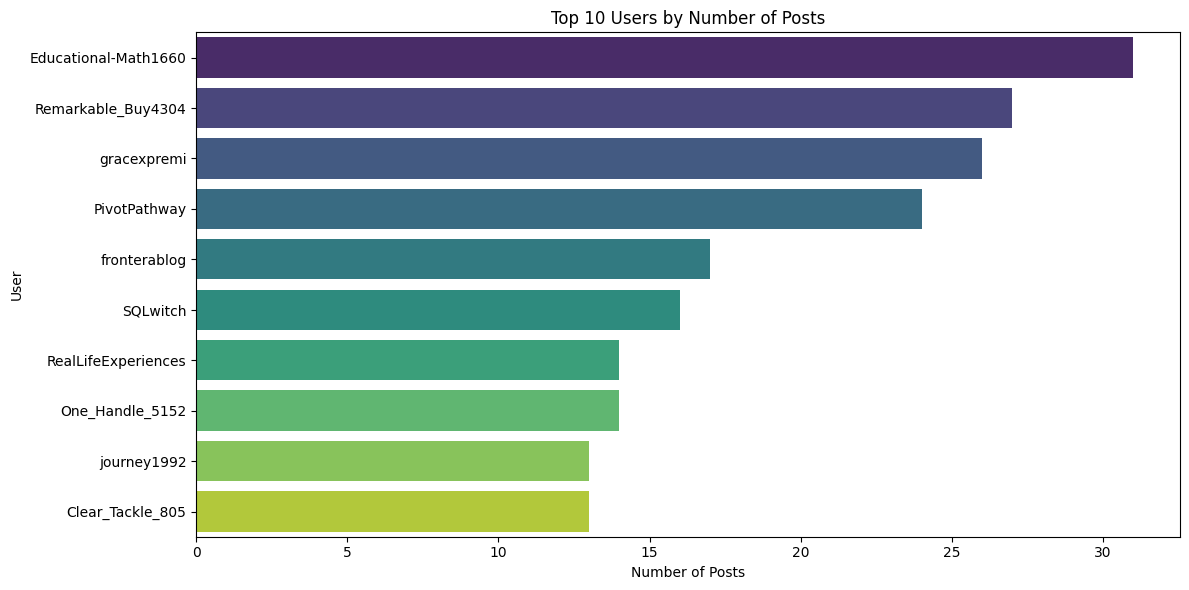

C:\Users\user\AppData\Local\Temp\ipykernel_15340\2197953381.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reddit_df, x='year', palette='viridis')


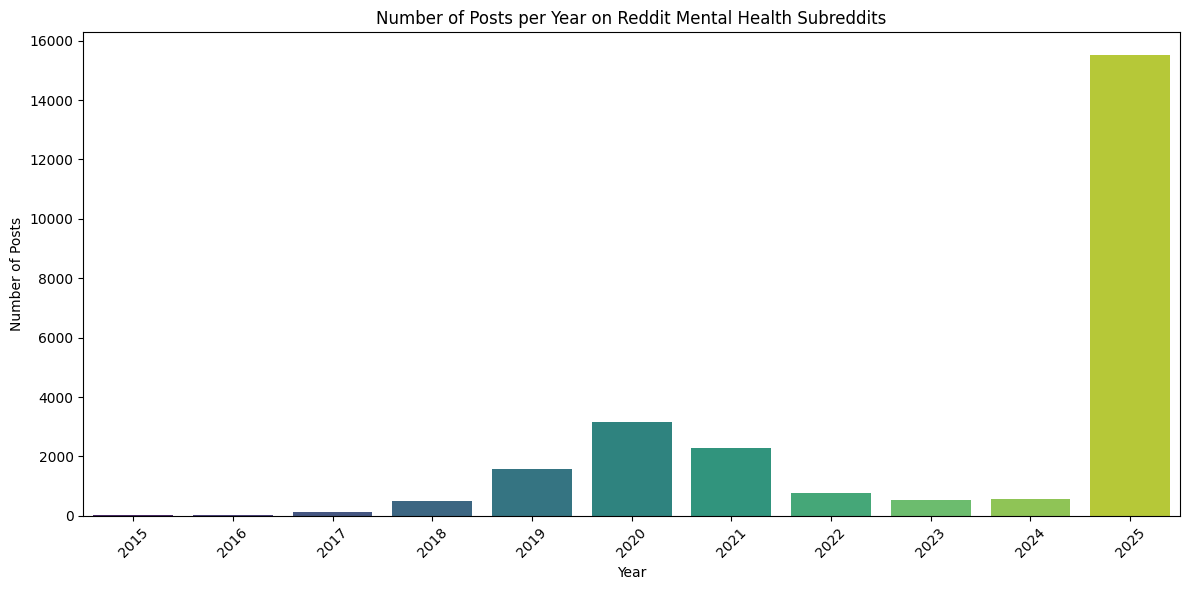

C:\Users\user\AppData\Local\Temp\ipykernel_15340\2197953381.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reddit_df, y='subreddit', order=reddit_df['subreddit'].value_counts().index, palette='viridis')


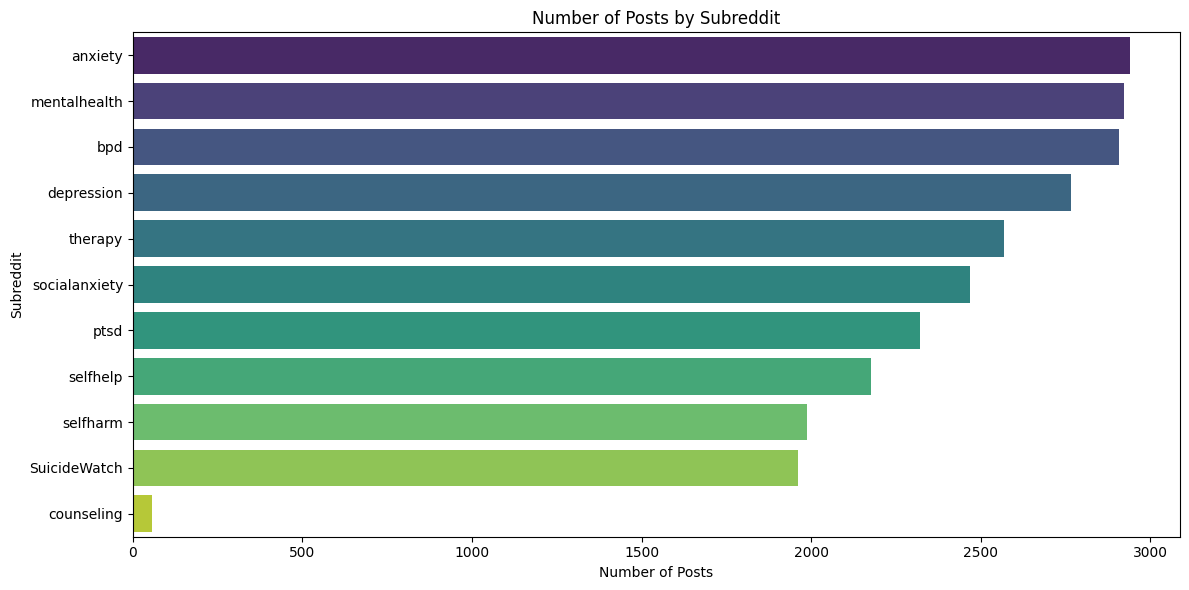

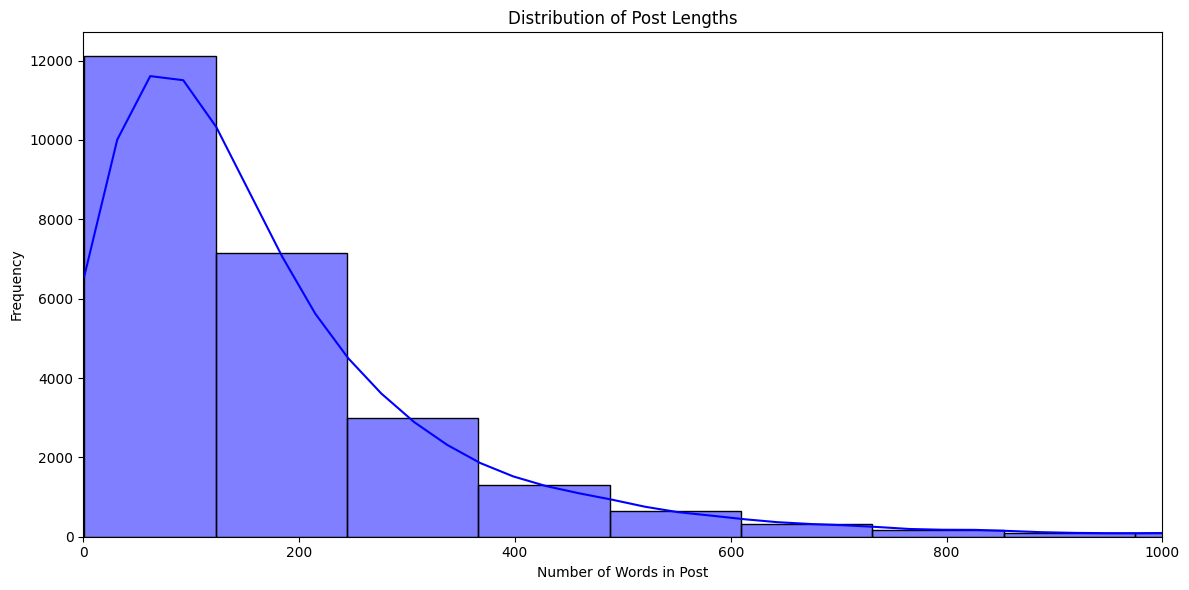

Top 20 N-grams (from 1 to 3 words):
N-gram: not, Count: 63961, Percentage: 0.53%
N-gram: go, Count: 43119, Percentage: 0.36%
N-gram: people, Count: 33834, Percentage: 0.28%
N-gram: make, Count: 31906, Percentage: 0.27%
N-gram: tng, Count: 28841, Percentage: 0.24%
N-gram: help, Count: 26162, Percentage: 0.22%
N-gram: s, Count: 25221, Percentage: 0.21%
N-gram: even, Count: 24492, Percentage: 0.20%
N-gram: say, Count: 24337, Percentage: 0.20%
N-gram: do, Count: 23931, Percentage: 0.20%
N-gram: try, Count: 23146, Percentage: 0.19%
N-gram: would, Count: 22411, Percentage: 0.19%
N-gram: one, Count: 22366, Percentage: 0.19%
N-gram: well, Count: 22262, Percentage: 0.19%
N-gram: you, Count: 21336, Percentage: 0.18%
N-gram: feel, Count: 21199, Percentage: 0.18%
N-gram: take, Count: 19538, Percentage: 0.16%
N-gram: need, Count: 19517, Percentage: 0.16%
N-gram: good, Count: 19466, Percentage: 0.16%
N-gram: do not, Count: 19220, Percentage: 0.16%

Last 20 N-grams (from 1 to 3 words):
N-gram: draw a

C:\Users\user\AppData\Local\Temp\ipykernel_15340\2197953381.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=ngram_df, palette='viridis')


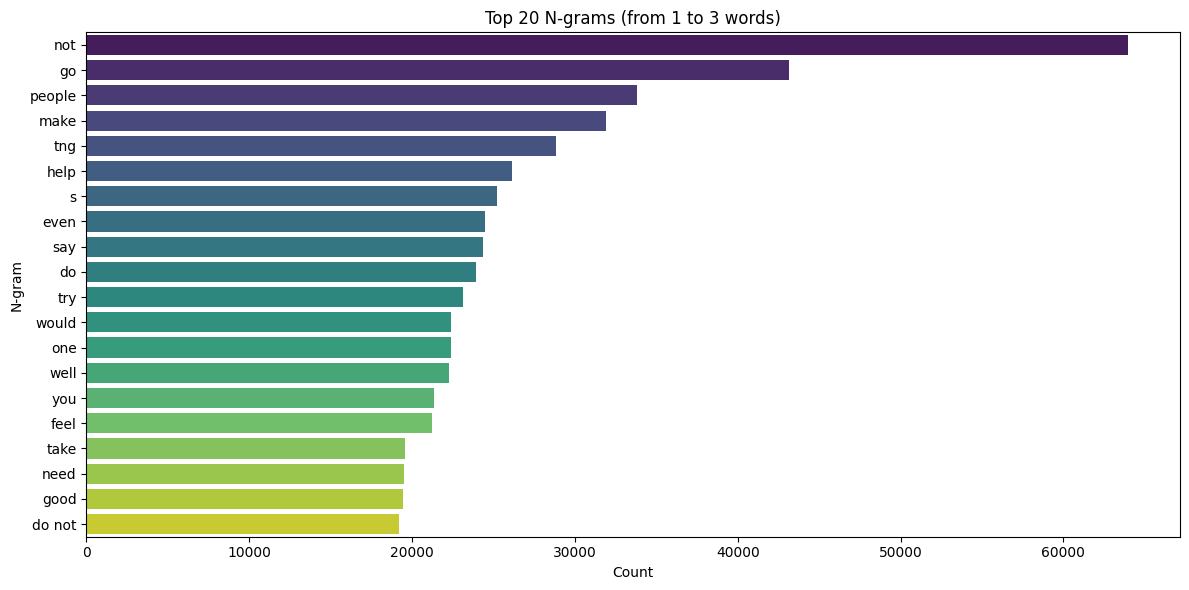

C:\Users\user\AppData\Local\Temp\ipykernel_15340\2197953381.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=last_ngram_df, palette='viridis')


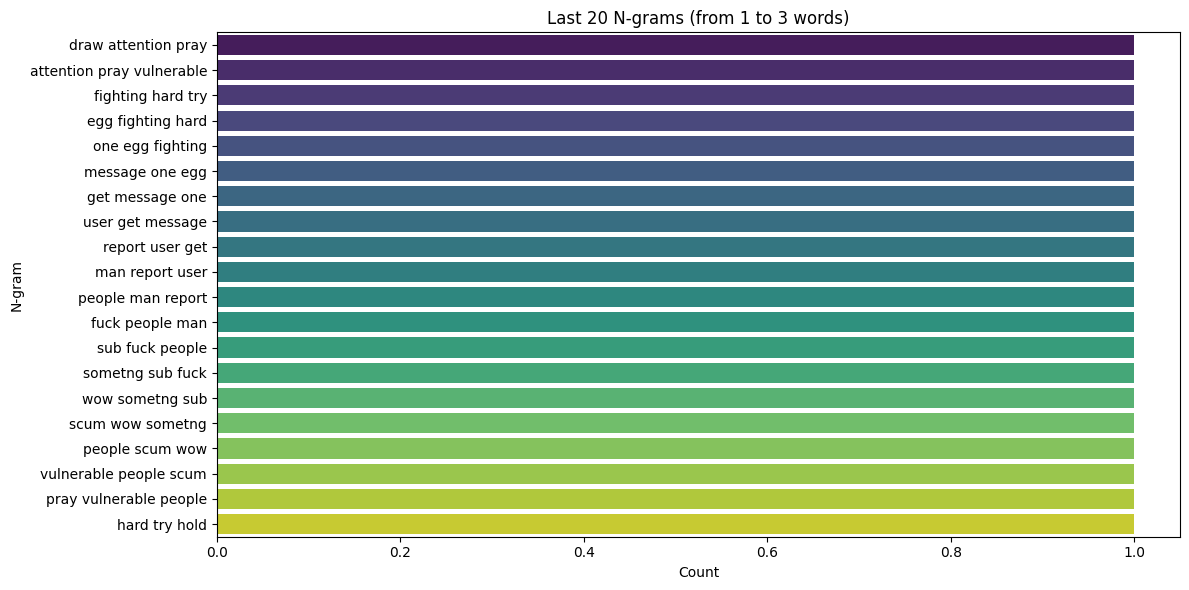

In [10]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


current_dir = os.getcwd()
reddit_df = pd.read_csv(os.path.join(current_dir, 'data', 'reddit_data', 'clean', 'cleaned_mental_all_text_2015up.csv')) 
lamme_reddit_df = " ".join(reddit_df['clean_title_selftext_topcomments_text'].tolist())





# check the total number of posts
total_posts = reddit_df.shape[0]
print(f"Total number of posts: {total_posts}")



# check the number of unique users
unique_users = reddit_df['author'].nunique()
print(f"Number of unique users: {unique_users}")


# plot the top 10 users who posted the most
top_users = reddit_df['author'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_users.values, y=top_users.index, palette='viridis')
plt.title('Top 10 Users by Number of Posts')
plt.xlabel('Number of Posts')
plt.ylabel('User')
plt.tight_layout()
plt.show()




# plot the number of posts per year
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'], errors='coerce')
reddit_df['year'] = reddit_df['created_utc'].dt.year
plt.figure(figsize=(12, 6))
sns.countplot(data=reddit_df, x='year', palette='viridis')
plt.title('Number of Posts per Year on Reddit Mental Health Subreddits')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# plot the number of posts by subreddit
plt.figure(figsize=(12, 6))
sns.countplot(data=reddit_df, y='subreddit', order=reddit_df['subreddit'].value_counts().index, palette='viridis')
plt.title('Number of Posts by Subreddit')
plt.xlabel('Number of Posts')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.show()


#plot the length of posts distribution 
reddit_df['post_length'] = (reddit_df['title'] + reddit_df['selftext']).apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.histplot(reddit_df['post_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Post Lengths')
plt.xlabel('Number of Words in Post')
plt.ylabel('Frequency')
plt.xlim(0, 1000)  # Limit x-axis to 500 words
plt.tight_layout()
plt.show()




# plot the top 10 frequence of tokens from the combination of unigrams, bigrams, and trigrams
from collections import Counter
import nltk
from nltk import ngrams
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns


def plot_top_ngrams(text, top_n = 10,last_top_n = 10, ngram_range= (1, 3)):
    tokens = word_tokenize(text.lower())
    ngram_counts = Counter()

    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngrams_list = ngrams(tokens, n)
        ngram_counts.update(ngrams_list)

    # Get the most common n-grams
    most_common_ngrams = ngram_counts.most_common(top_n)
    last_most_common_ngrams = ngram_counts.most_common()[-last_top_n:]

    # also show the percentage of each top_n from the total count
    total_count = sum(ngram_counts.values())
    most_common_ngrams = [(ngram, count, count / total_count * 100) for ngram, count in most_common_ngrams]
    last_most_common_ngrams = [(ngram, count, count / total_count * 100) for ngram, count in last_most_common_ngrams]

    print(f"Top {top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words):")
    for ngram, count, percentage in most_common_ngrams:
        print(f"N-gram: {' '.join(ngram)}, Count: {count}, Percentage: {percentage:.2f}%")

    print(f"\nLast {last_top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words):")
    for ngram, count, percentage in last_most_common_ngrams:
        print(f"N-gram: {' '.join(ngram)}, Count: {count}, Percentage: {percentage:.2f}%")

    
    #plot the top_n and last_top_n ngrams seperately
    ngram_df = pd.DataFrame(most_common_ngrams, columns=['N-gram', 'Count', 'Percentage'])
    ngram_df['N-gram'] = ngram_df['N-gram'].apply(lambda x: ' '.join(x))
    ngram_df = ngram_df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(f'Top {top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words)')
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()

    # Prepare data for plotting last ngrams
    last_ngram_df = pd.DataFrame(last_most_common_ngrams, columns=['N-gram', 'Count', 'Percentage'])
    last_ngram_df['N-gram'] = last_ngram_df['N-gram'].apply(lambda x: ' '.join(x))
    last_ngram_df = last_ngram_df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='N-gram', data=last_ngram_df, palette='viridis')
    plt.title(f'Last {last_top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words)')
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()


    
plot_top_ngrams(lamme_reddit_df, top_n=20,last_top_n=20, ngram_range=(1, 3))


Beyondblue Data

Total number of posts in Beyond Blue: 23802
Number of unique users in Beyond Blue: 8905


C:\Users\user\AppData\Local\Temp\ipykernel_36372\1650860271.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users_beyondblue.values, y=top_users_beyondblue.index, palette='viridis')


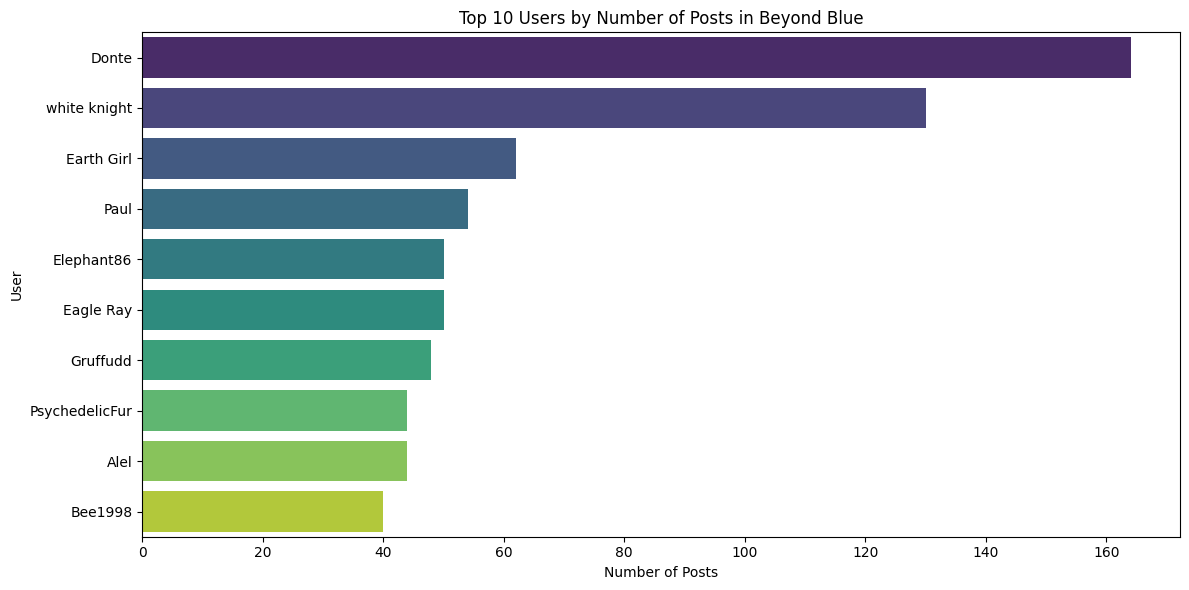

C:\Users\user\AppData\Local\Temp\ipykernel_36372\1650860271.py:38: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  beyondblue_df['Post Date'] = pd.to_datetime(beyondblue_df['Post Date'], errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_36372\1650860271.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=beyondblue_df, x='year', palette='viridis')


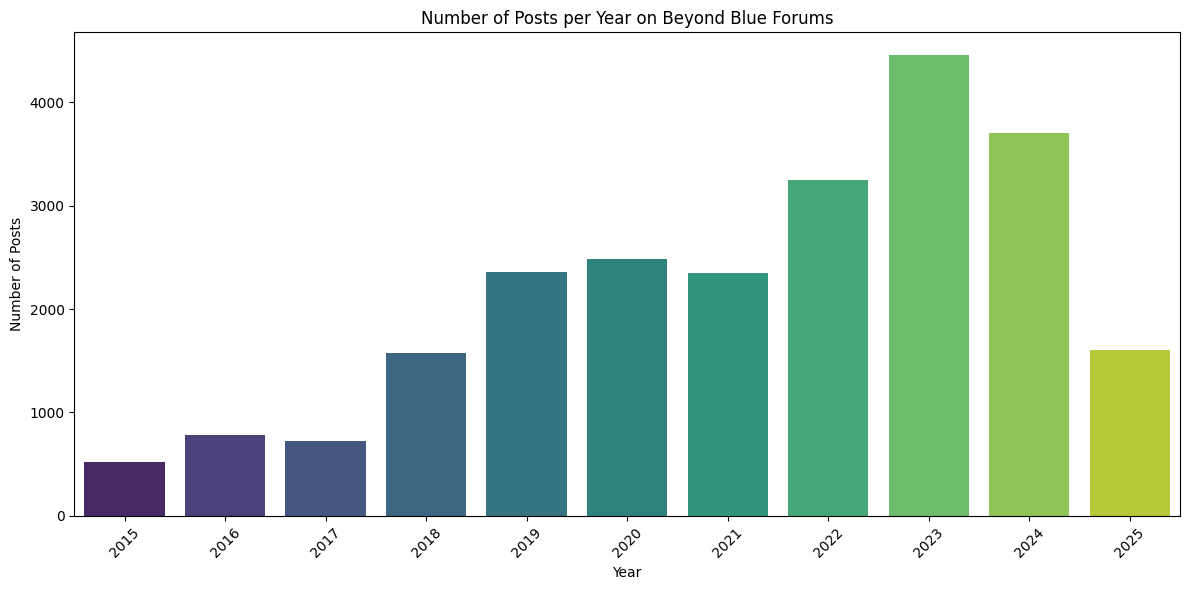

C:\Users\user\AppData\Local\Temp\ipykernel_36372\1650860271.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=beyondblue_df, y='Post Category', order=beyondblue_df['Post Category'].value_counts().index, palette='viridis')


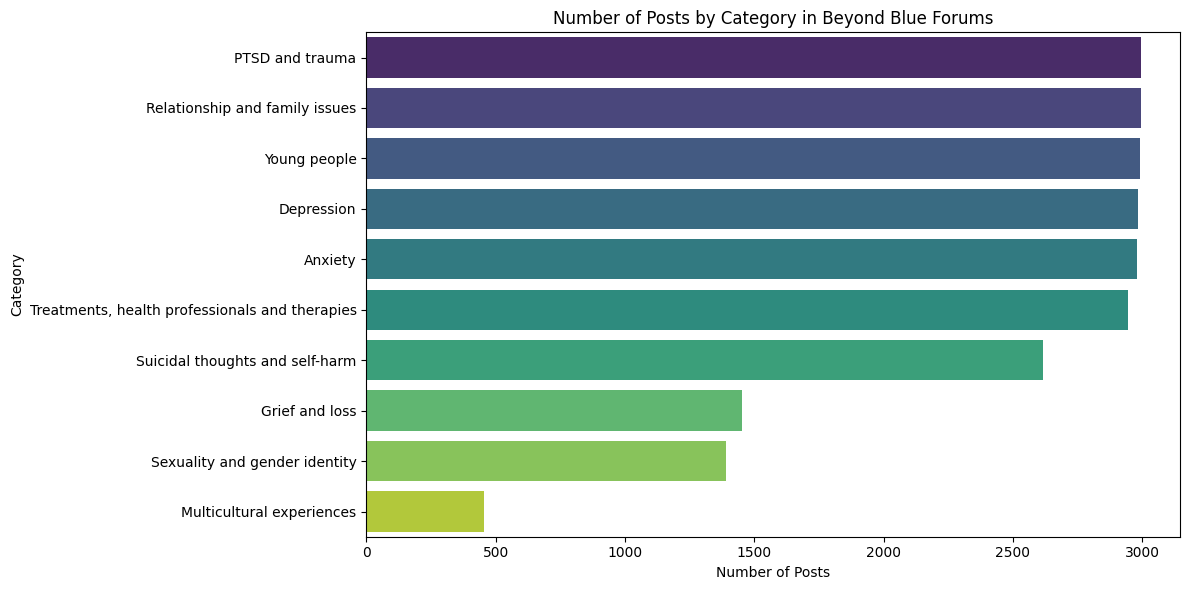

Post Category
PTSD and trauma                                   2996
Relationship and family issues                    2994
Young people                                      2990
Depression                                        2982
Anxiety                                           2978
Treatments, health professionals and therapies    2944
Suicidal thoughts and self-harm                   2617
Grief and loss                                    1454
Sexuality and gender identity                     1391
Multicultural experiences                          456
Name: count, dtype: int64


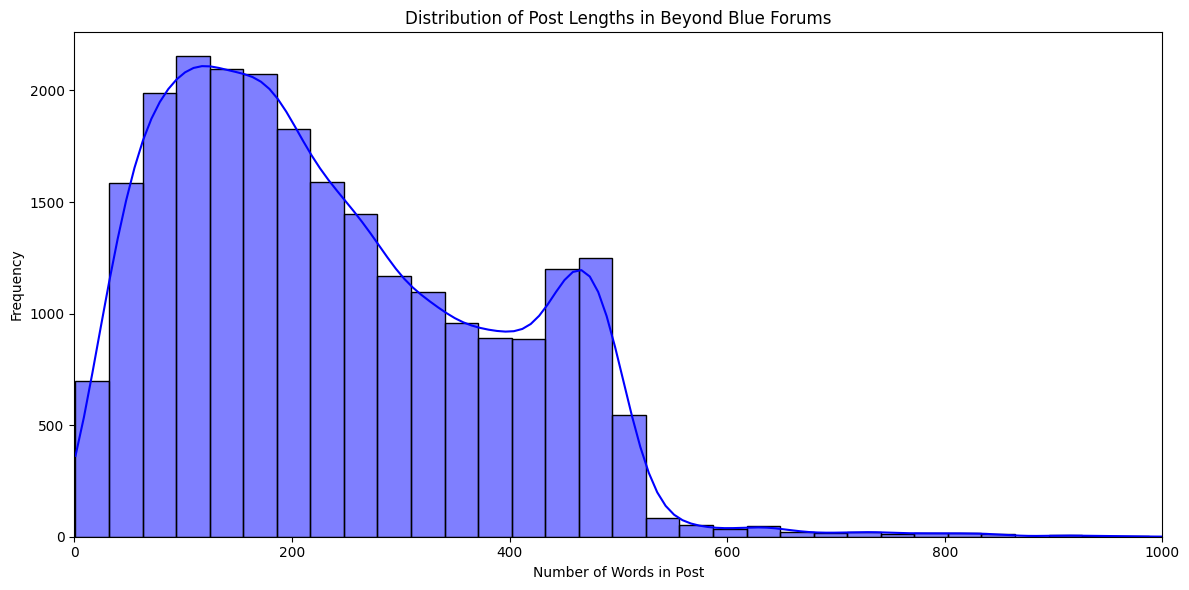

Top 20 N-grams (from 1 to 2 words):
N-gram: not, Count: 109762, Percentage: 0.54%
N-gram: go, Count: 96223, Percentage: 0.48%
N-gram: help, Count: 83129, Percentage: 0.41%
N-gram: tng, Count: 75131, Percentage: 0.37%
N-gram: people, Count: 66392, Percentage: 0.33%
N-gram: would, Count: 66250, Percentage: 0.33%
N-gram: make, Count: 63562, Percentage: 0.31%
N-gram: one, Count: 62511, Percentage: 0.31%
N-gram: well, Count: 60276, Percentage: 0.30%
N-gram: say, Count: 59618, Percentage: 0.30%
N-gram: find, Count: 58352, Percentage: 0.29%
N-gram: good, Count: 56817, Percentage: 0.28%
N-gram: take, Count: 56141, Percentage: 0.28%
N-gram: need, Count: 53982, Percentage: 0.27%
N-gram: way, Count: 53098, Percentage: 0.26%
N-gram: also, Count: 52957, Percentage: 0.26%
N-gram: feel, Count: 52634, Percentage: 0.26%
N-gram: see, Count: 52399, Percentage: 0.26%
N-gram: work, Count: 52090, Percentage: 0.26%
N-gram: try, Count: 50609, Percentage: 0.25%

Last 20 N-grams (from 1 to 2 words):
N-gram: luc

C:\Users\user\AppData\Local\Temp\ipykernel_36372\1650860271.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=ngram_df, palette='viridis')


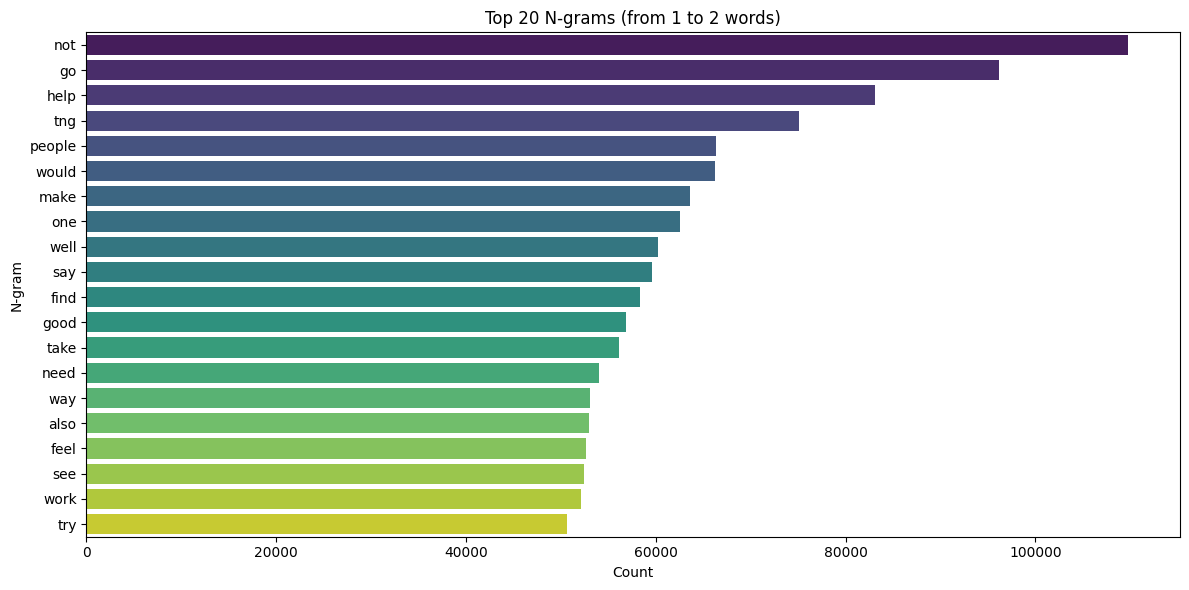

C:\Users\user\AppData\Local\Temp\ipykernel_36372\1650860271.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=last_ngram_df, palette='viridis')


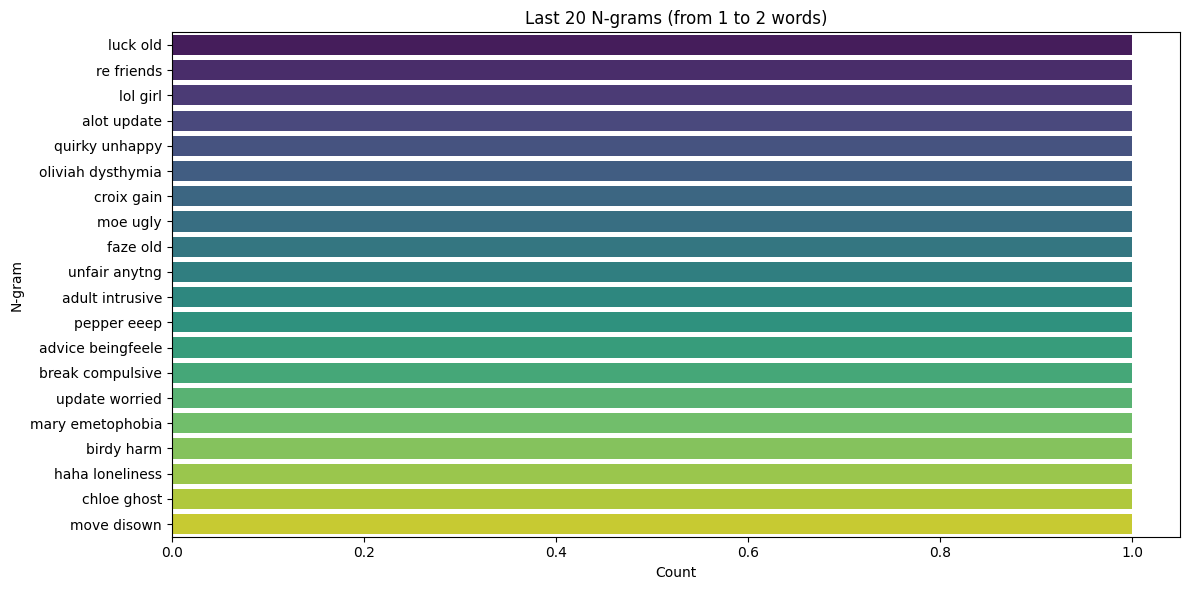

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

current_dir = os.getcwd()
beyondblue_df = pd.read_csv(os.path.join(current_dir, 'data', 'beyondblue_data', 'clean', 'cleaned_beyondblue_all_text_2015up.csv'))
lamme_beyondblue_df = " ".join(beyondblue_df['clean_title_content_comments'].tolist())




# check the total number of posts
total_posts_beyondblue = beyondblue_df.shape[0]
print(f"Total number of posts in Beyond Blue: {total_posts_beyondblue}")


# check the number of unique users
unique_users_beyondblue = beyondblue_df['Post Author'].nunique()
print(f"Number of unique users in Beyond Blue: {unique_users_beyondblue}")





# plot the top 10 users who posted the most
top_users_beyondblue = beyondblue_df['Post Author'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_users_beyondblue.values, y=top_users_beyondblue.index, palette='viridis')
plt.title('Top 10 Users by Number of Posts in Beyond Blue')
plt.xlabel('Number of Posts')
plt.ylabel('User')
plt.tight_layout()
plt.show()


# plot the number of posts per year
beyondblue_df['Post Date'] = pd.to_datetime(beyondblue_df['Post Date'], errors='coerce')
beyondblue_df['year'] = beyondblue_df['Post Date'].dt.year
plt.figure(figsize=(12, 6))
sns.countplot(data=beyondblue_df, x='year', palette='viridis')
plt.title('Number of Posts per Year on Beyond Blue Forums')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
# Save as SVG in current directory
svg_filename = "beyondblue_num.svg"
plt.savefig(os.path.join(current_dir, svg_filename), format='svg')
plt.show()


# plot the number of posts by subreddit
plt.figure(figsize=(12, 6))
sns.countplot(data=beyondblue_df, y='Post Category', order=beyondblue_df['Post Category'].value_counts().index, palette='viridis')
plt.title('Number of Posts by Category in Beyond Blue Forums')
plt.xlabel('Number of Posts')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

print(beyondblue_df['Post Category'].value_counts())


#plot the length of posts distribution 
beyondblue_df['post_length'] = (beyondblue_df['Post Title'] + beyondblue_df['Post Content']).apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.histplot(beyondblue_df['post_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Post Lengths in Beyond Blue Forums')
plt.xlabel('Number of Words in Post')
plt.ylabel('Frequency')
plt.xlim(0, 1000)  # Limit x-axis to 500 words
plt.tight_layout()
# Save as SVG in current directory
svg_filename = "beyondblue_length.svg"
plt.savefig(os.path.join(current_dir, svg_filename), format='svg')
plt.show()






# plot the top 10 and last top 10  frequence of tokens from the combination of unigrams, bigrams, and trigrams
from collections import Counter
import nltk
from nltk import ngrams
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_ngrams(text, top_n = 10,last_top_n = 10, ngram_range= (1, 3)):
    tokens = word_tokenize(text.lower())
    ngram_counts = Counter()

    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngrams_list = ngrams(tokens, n)
        ngram_counts.update(ngrams_list)

    # Get the most common n-grams
    most_common_ngrams = ngram_counts.most_common(top_n)
    last_most_common_ngrams = ngram_counts.most_common()[-last_top_n:]

    # also show the percentage of each top_n from the total count
    total_count = sum(ngram_counts.values())
    most_common_ngrams = [(ngram, count, count / total_count * 100) for ngram, count in most_common_ngrams]
    last_most_common_ngrams = [(ngram, count, count / total_count * 100) for ngram, count in last_most_common_ngrams]

    print(f"Top {top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words):")
    for ngram, count, percentage in most_common_ngrams:
        print(f"N-gram: {' '.join(ngram)}, Count: {count}, Percentage: {percentage:.2f}%")

    print(f"\nLast {last_top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words):")
    for ngram, count, percentage in last_most_common_ngrams:
        print(f"N-gram: {' '.join(ngram)}, Count: {count}, Percentage: {percentage:.2f}%")

    
    #plot the top_n and last_top_n ngrams seperately
    ngram_df = pd.DataFrame(most_common_ngrams, columns=['N-gram', 'Count', 'Percentage'])
    ngram_df['N-gram'] = ngram_df['N-gram'].apply(lambda x: ' '.join(x))
    ngram_df = ngram_df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(f'Top {top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words)')
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()

    # Prepare data for plotting last ngrams
    last_ngram_df = pd.DataFrame(last_most_common_ngrams, columns=['N-gram', 'Count', 'Percentage'])
    last_ngram_df['N-gram'] = last_ngram_df['N-gram'].apply(lambda x: ' '.join(x))
    last_ngram_df = last_ngram_df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='N-gram', data=last_ngram_df, palette='viridis')
    plt.title(f'Last {last_top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words)')
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()


    
plot_top_ngrams(lamme_beyondblue_df, top_n=20,last_top_n=20, ngram_range=(1, 2))







Generating word cloud for: Anxiety


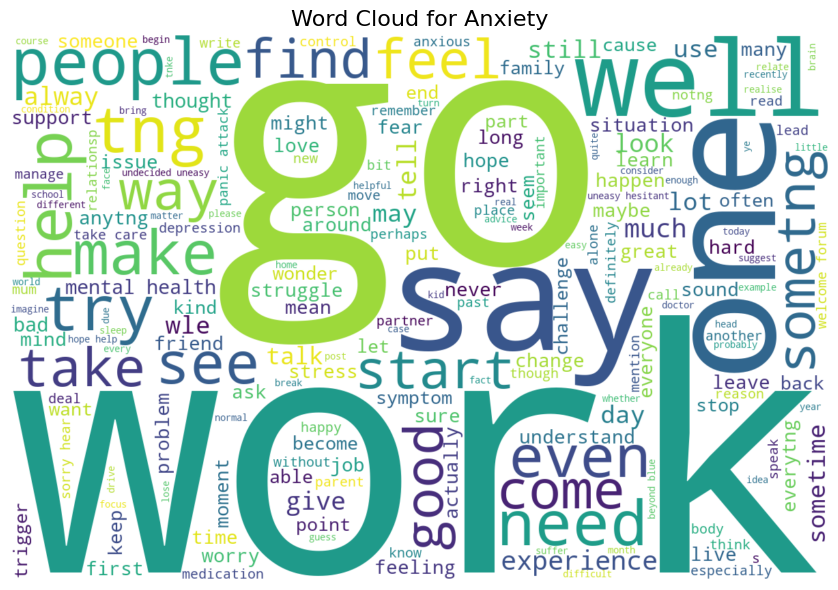


Generating word cloud for: Depression


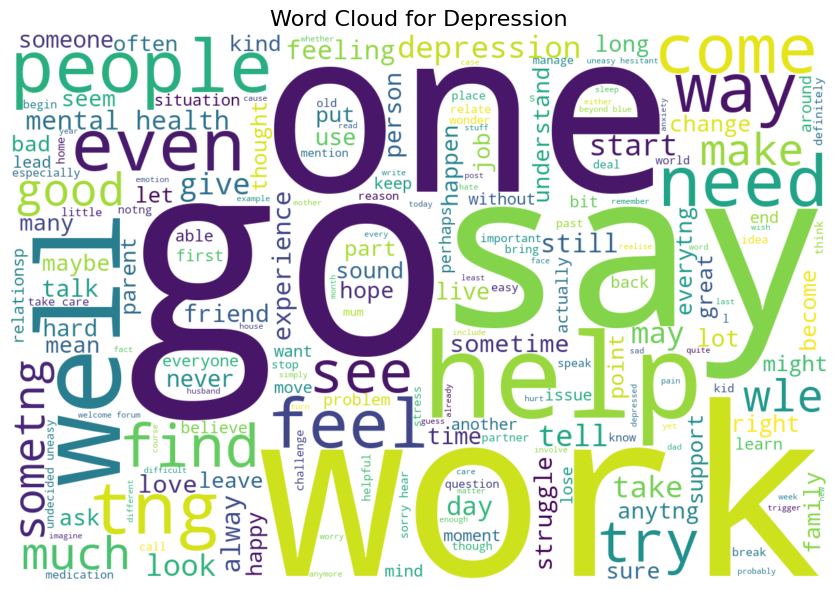


Generating word cloud for: PTSD and trauma


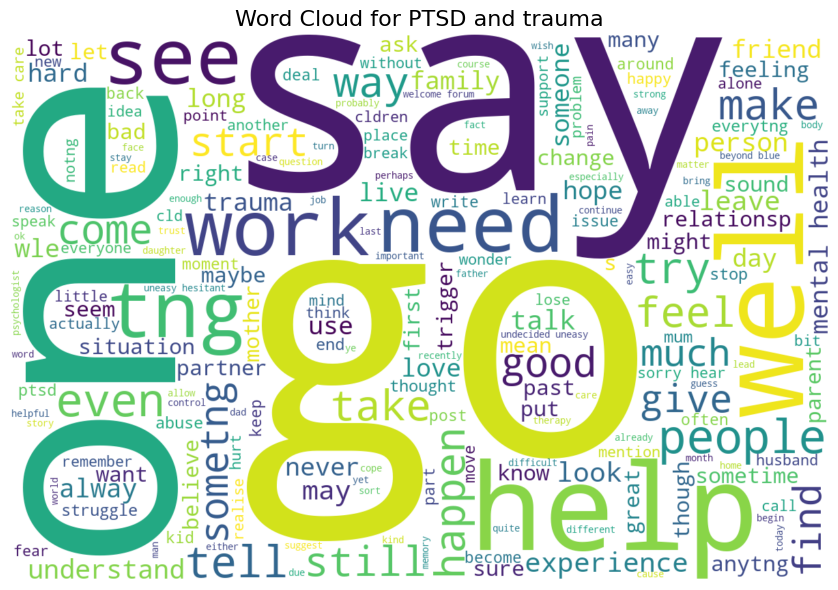


Generating word cloud for: Suicidal thoughts and self-harm


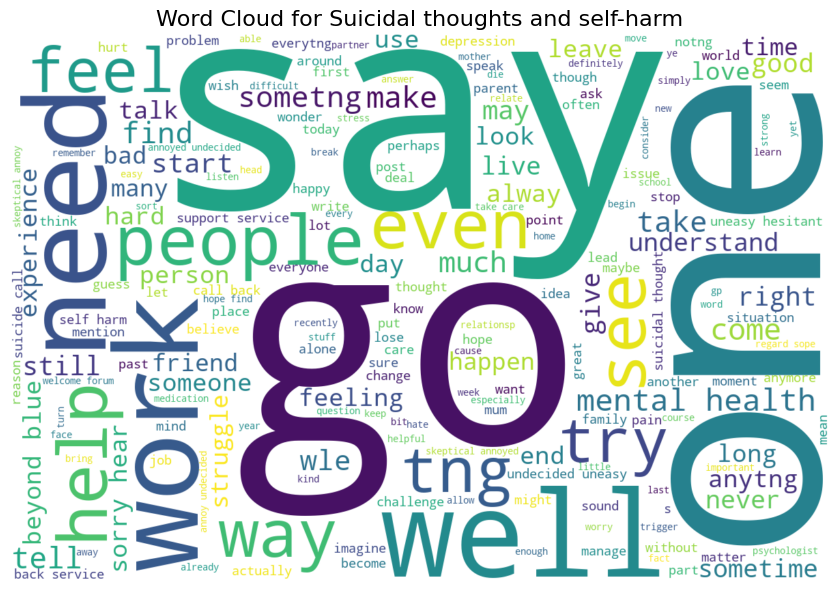

In [2]:

import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud


current_dir = os.getcwd()
platform = "beyondblue"
labels = ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"]

for label in labels:
    print(f"\nGenerating word cloud for: {label}")
    
    # Path to label folder
    label_dir = os.path.join(current_dir, 'data', f'{platform}_data', 'berttopic_label', label)
    
    lemma_file_path = os.path.join(label_dir, 'lemma_dc')
    if not os.path.exists(lemma_file_path):
        print(f"Missing file: {lemma_file_path}")
        continue

    # Load lemmatized documents
    with open(lemma_file_path, 'r', encoding='utf-8') as f:
        lemma_dc = [line.strip() for line in f if line.strip()]

    if not lemma_dc:
        print(f"No lemmatized documents found for label '{label}'.")
        continue

    # Combine all text
    text = " ".join(lemma_dc)

    # Generate the word cloud
    wc = WordCloud(width=1200, height=800, background_color='white', max_words=200, colormap='viridis').generate(text)

    # Plot it
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {label}", fontsize=16)
    plt.tight_layout()


    # Save as SVG in current directory
    svg_filename = f"{label.replace(' ', '_')}_wordcloud.svg"
    plt.savefig(os.path.join(current_dir, svg_filename), format='svg')


    plt.show()
    

